In [1]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import resize
from skimage import io
import pickle
from skimage.measure import regionprops

import matplotlib.pyplot as plt
import torch
import time
import model.model_cnnvae_conditional
import model.optimizer as optimizer
from sklearn.decomposition import PCA
import pandas as pd
import torchvision

In [2]:
prevSampled=0
nSamples=36
nProt=6
holdOutSamples_samples=[['HV1','P22','P14','P27'],['HV3','P46','P24','P37'],['HV5','P68','P44','P42'],['HV7','P15','P55','P59'],['HV8','P47','P63','P70'],['HV2','P57','P72','P83']]

In [3]:
sourceDir='/data/xinyi/c2p/data/chromark'
segDir=os.path.join(sourceDir,'nuclear_masks')
imgDir=os.path.join(sourceDir,'raw_data')
conditions=['controls','headneck','meningioma', 'glioma']

outSize=128
savename='pathCentered_'+str(outSize)



In [5]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [6]:
seed=3
epochs=5001
saveFreq=50
lr=0.0001
weight_decay=0 #Weight for L2 loss on embedding matrix.

batchsize=256

In [7]:
def train(epoch,model_clf,optimizer_clf,inputImgs,inputImgs_val,labels_train,labels_val):
    np.random.seed(3)
    train_nodes_idx=np.arange(labels_train.size()[0])
    val_nodes_idx=np.arange(labels_val.size()[0])
    np.random.shuffle(train_nodes_idx)
    t = time.time()
    model_clf.train()
    loss_all=0
    
    ntrainBatches=int(np.ceil(train_nodes_idx.shape[0]/batchsize))
    for i in range(ntrainBatches):
#         if i%200==0:
#             print(i)
        trainIdx=train_nodes_idx[i*batchsize:min((i+1)*batchsize,train_nodes_idx.shape[0])]
        train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
        trainInput=torch.tensor(inputImgs[trainIdx]).cuda().float()

        optimizer_clf.zero_grad()

        pred = model_clf(trainInput)

        loss=loss_clf(pred, train_labels)
        loss_all+=loss.item()
            
        loss.backward()
        optimizer_clf.step()

    loss_all=loss_all/ntrainBatches
    
    with torch.no_grad():
        model_clf.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(val_nodes_idx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx=val_nodes_idx[i*batchsize:min((i+1)*batchsize,val_nodes_idx.shape[0])]
            val_labels=torch.tensor(labels_val[valIdx]).cuda().long()
            valInput=torch.tensor(inputImgs_val[valIdx]).cuda().float()


            pred = model_clf(valInput)

            loss=loss_clf(pred, val_labels)
            loss_val_all+=loss.item()

        loss_val_all=loss_val_all/nvalBatches
    
    print(' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_val: {:.4f}'.format(loss_val_all),
          'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_val_all








In [8]:
name_train='conditionClf_c2c_sharedrecon_sampling'
modelname_train='resnet18'
logsavepath_train=os.path.join('/data/xinyi/c2p/log/',modelname_train,name_train)
modelsavepath_train=os.path.join('/data/xinyi/c2p/models/',modelname_train,name_train)
plotsavepath_train=os.path.join('/data/xinyi/c2p/plots/',modelname_train,name_train)

if not os.path.exists(os.path.join('/data/xinyi/c2p/log/',modelname_train)):
    os.mkdir(os.path.join('/data/xinyi/c2p/log/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/models/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/plots/',modelname_train))
if not os.path.exists(logsavepath_train):
    os.mkdir(logsavepath_train)
if not os.path.exists(modelsavepath_train):
    os.mkdir(modelsavepath_train)
if not os.path.exists(plotsavepath_train):
    os.mkdir(plotsavepath_train)

### load lord

In [9]:
sharedSizes=[1024]
dSpecific_filter=[(200,16)]
pID_type='randInit'
pIDemb_size=64

#VAE settings
seed=3
epochs=5001
saveFreq=100
lr=0.001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=256
kernel_size=4
stride=2
padding=1

# fc_dim1=6000
hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=256
hidden5=96
hidden5_xy=4
fc_dim1=96*hidden5_xy*hidden5_xy
fc_dim2=6000

dropout=0.01
kl_weight=0.0000001


name_lord='splitChannels_conditional_lord_withNoise_bce'
modelname_lord='cnn_vae_pbmc_lord'
logsavepath_lord=os.path.join('/data/xinyi/c2p/log/',modelname_lord,name_lord)
modelsavepath_lord=os.path.join('/data/xinyi/c2p/models/',modelname_lord,name_lord)
plotsavepath_lord=os.path.join('/data/xinyi/c2p/plots/',modelname_lord,name_lord)

loadEpoch='3399'
loadEpoch_decoder=372

logsavepath_p_dna=os.path.join(logsavepath_lord,'dna')
modelsavepath_p_dna=os.path.join(modelsavepath_lord,'dna')
plotsavepath_p_dna=os.path.join(plotsavepath_lord,'dna')

logsavepath_p_protein=os.path.join(logsavepath_lord,'protein')
modelsavepath_p_protein=os.path.join(modelsavepath_lord,'protein')
plotsavepath_p_protein=os.path.join(plotsavepath_lord,'protein')

currLatentSize=sharedSizes[0]
dSpecificSize,dfilterSize=dSpecific_filter[0]

dna_cShared=hidden5-dfilterSize
p_cShared=dna_cShared

if modelname_lord=='cnn_vae_pbmc_lord':
    modelcnn_dna_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size)
    modelcnn_protein_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size)
    modelcnn_dnaShared_dec=model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize,pIDemb_size)
    modelcnn_pShared_dec=model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize,pIDemb_size)
modelcnn_dna_dec.cuda().eval()
modelcnn_protein_dec.cuda().eval()
modelcnn_dnaShared_dec.cuda().eval()
modelcnn_pShared_dec.cuda().eval()

batchsize=328
pIDemb_dec=torch.nn.Embedding(nProt, pIDemb_size).cuda()


with open(os.path.join(modelsavepath_p_protein,'pIDemb_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'rb') as output:
    pIDemb_dec.weight=pickle.load(output)

with open(os.path.join(modelsavepath_p_dna,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_dna_dec=pickle.load(output)
with open(os.path.join(modelsavepath_p_protein,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_protein_dec=pickle.load(output)
with open(os.path.join(modelsavepath_p_dna,'stateDictShared_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_dnaShared_dec=pickle.load(output)
with open(os.path.join(modelsavepath_p_protein,'stateDictShared_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_proteinShared_dec=pickle.load(output)

modelcnn_dna_dec.load_state_dict(stateDict_train_dna_dec[int(loadEpoch)])
modelcnn_dnaShared_dec.load_state_dict(stateDict_train_dnaShared_dec[int(loadEpoch)])
modelcnn_protein_dec.load_state_dict(stateDict_train_protein_dec[int(loadEpoch)])
modelcnn_pShared_dec.load_state_dict(stateDict_train_proteinShared_dec[int(loadEpoch)])
pIDemb_dec.weight.requires_grad=False

with open(os.path.join(modelsavepath_p_dna,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_dna=pickle.load( output)
with open(os.path.join(modelsavepath_p_protein,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_protein=pickle.load(output)

if modelname_lord=='cnn_vae_pbmc_lord':
    modelcnn_dna = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,dna_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,nProt,'randInit',pIDemb_size)
    modelcnn_protein = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,p_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,nProt,'randInit',pIDemb_size)
modelcnn_dna.cuda()
modelcnn_protein.cuda()
modelcnn_dna.load_state_dict(stateDict_train_dna[loadEpoch_decoder])
modelcnn_protein.load_state_dict(stateDict_train_protein[loadEpoch_decoder])






<All keys matched successfully>

18
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554845/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554845/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9220 loss_val: 2.0177 time: 16.2905s
 Epoch: 0001 loss_train: 0.7924 loss_val: 0.8837 time: 14.6474s
 Epoch: 0002 loss_train: 0.7505 loss_val: 0.9590 time: 15.4015s
 Epoch: 0003 loss_train: 0.7197 loss_val: 1.0284 time: 15.3576s
 Epoch: 0004 loss_train: 0.6864 loss_val: 0.9659 time: 14.3280s
 Epoch: 0005 loss_train: 0.6653 loss_val: 1.4901 time: 16.0824s
 Epoch: 0006 loss_train: 0.6472 loss_val: 1.1567 time: 17.8425s
 Epoch: 0007 loss_train: 0.6241 loss_val: 2.4785 time: 15.8660s
 Epoch: 0008 loss_train: 0.6015 loss_val: 2.0230 time: 15.9998s
 Epoch: 0009 loss_train: 0.5766 loss_val: 1.5641 time: 15.7934s
 Epoch: 0010 loss_train: 0.5402 loss_val: 0.8432 time: 16.3500s
 Epoch: 0011 loss_train: 0.5032 loss_val: 1.5496 time: 16.7867s
 Epoch: 0012 loss_train: 0.4705 loss_val: 1.4985 time: 14.0398s
 Epoch: 0013 loss_train: 0.4397 loss_val: 1.7734 time: 21.1263s
 Epoch: 0014 loss_train: 0.3898 loss_val: 1.5435 time: 21.1838s
 Epoch: 0015 loss_train: 0.3702 loss_val

 Epoch: 0133 loss_train: 0.0025 loss_val: 2.0843 time: 27.5454s
 Epoch: 0134 loss_train: 0.0023 loss_val: 2.0967 time: 27.3196s
 Epoch: 0135 loss_train: 0.0029 loss_val: 2.1587 time: 27.7888s
 Epoch: 0136 loss_train: 0.0030 loss_val: 2.2312 time: 28.4661s
 Epoch: 0137 loss_train: 0.0026 loss_val: 2.1802 time: 28.3878s
 Epoch: 0138 loss_train: 0.0014 loss_val: 2.2277 time: 26.9331s
 Epoch: 0139 loss_train: 0.0012 loss_val: 2.2666 time: 27.5021s
 Epoch: 0140 loss_train: 0.0018 loss_val: 2.2378 time: 28.1728s
 Epoch: 0141 loss_train: 0.0016 loss_val: 2.3009 time: 27.6676s
 Epoch: 0142 loss_train: 0.0018 loss_val: 2.2715 time: 28.5810s
 Epoch: 0143 loss_train: 0.0017 loss_val: 2.3260 time: 27.4685s
 Epoch: 0144 loss_train: 0.0017 loss_val: 2.3365 time: 26.5914s
 Epoch: 0145 loss_train: 0.0012 loss_val: 2.3325 time: 27.1977s
 Epoch: 0146 loss_train: 0.0006 loss_val: 2.3563 time: 27.1244s
 Epoch: 0147 loss_train: 0.0004 loss_val: 2.3636 time: 25.6615s
 Epoch: 0148 loss_train: 0.0005 loss_val

 Epoch: 0262 loss_train: 0.0007 loss_val: 2.0701 time: 28.2873s
 Epoch: 0263 loss_train: 0.0005 loss_val: 2.0538 time: 28.1972s
 Epoch: 0264 loss_train: 0.0004 loss_val: 2.0757 time: 27.5291s
 Epoch: 0265 loss_train: 0.0002 loss_val: 2.1054 time: 28.1244s
 Epoch: 0266 loss_train: 0.0001 loss_val: 2.1228 time: 27.9140s
 Epoch: 0267 loss_train: 0.0001 loss_val: 2.1441 time: 27.0067s
 Epoch: 0268 loss_train: 0.0001 loss_val: 2.1517 time: 28.4223s
 Epoch: 0269 loss_train: 0.0001 loss_val: 2.1733 time: 27.3689s
 Epoch: 0270 loss_train: 0.0001 loss_val: 2.1812 time: 27.5421s
 Epoch: 0271 loss_train: 0.0001 loss_val: 2.1992 time: 28.1087s
 Epoch: 0272 loss_train: 0.0001 loss_val: 2.2070 time: 27.6234s
 Epoch: 0273 loss_train: 0.0001 loss_val: 2.2252 time: 27.6252s
 Epoch: 0274 loss_train: 0.0001 loss_val: 2.2297 time: 29.9495s
 Epoch: 0275 loss_train: 0.0001 loss_val: 2.2483 time: 29.1078s
 Epoch: 0276 loss_train: 0.0001 loss_val: 2.2499 time: 28.7529s
 Epoch: 0277 loss_train: 0.0001 loss_val

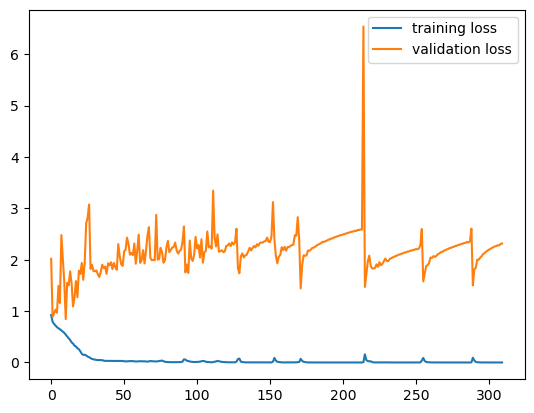

19
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554845/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554845/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9543 loss_val: 1.1203 time: 28.7035s
 Epoch: 0001 loss_train: 0.8374 loss_val: 1.1884 time: 27.1234s
 Epoch: 0002 loss_train: 0.7968 loss_val: 0.9635 time: 28.4175s
 Epoch: 0003 loss_train: 0.7733 loss_val: 1.0368 time: 26.4237s
 Epoch: 0004 loss_train: 0.7405 loss_val: 1.1085 time: 28.5011s
 Epoch: 0005 loss_train: 0.7134 loss_val: 1.5560 time: 27.6570s
 Epoch: 0006 loss_train: 0.6850 loss_val: 1.1241 time: 29.4472s
 Epoch: 0007 loss_train: 0.6637 loss_val: 1.0389 time: 27.5587s
 Epoch: 0008 loss_train: 0.6483 loss_val: 1.1873 time: 28.1566s
 Epoch: 0009 loss_train: 0.6043 loss_val: 1.2916 time: 26.7512s
 Epoch: 0010 loss_train: 0.5745 loss_val: 1.1390 time: 28.0989s
 Epoch: 0011 loss_train: 0.5341 loss_val: 0.9933 time: 27.6370s
 Epoch: 0012 loss_train: 0.4930 loss_val: 1.2894 time: 28.3689s
 Epoch: 0013 loss_train: 0.4512 loss_val: 2.0974 time: 27.7205s
 Epoch: 0014 loss_train: 0.4131 loss_val: 1.5728 time: 27.7904s
 Epoch: 0015 loss_train: 0.3634 loss_val

 Epoch: 0129 loss_train: 0.0000 loss_val: 2.9212 time: 27.7477s
 Epoch: 0130 loss_train: 0.0000 loss_val: 2.9275 time: 27.2196s
 Epoch: 0131 loss_train: 0.0000 loss_val: 2.9338 time: 27.5439s
 Epoch: 0132 loss_train: 0.0000 loss_val: 2.9401 time: 27.4825s
 Epoch: 0133 loss_train: 0.0000 loss_val: 2.9464 time: 27.9398s
 Epoch: 0134 loss_train: 0.0000 loss_val: 2.9526 time: 27.2166s
 Epoch: 0135 loss_train: 0.0000 loss_val: 2.9589 time: 28.4387s
 Epoch: 0136 loss_train: 0.0000 loss_val: 2.9651 time: 27.8668s
 Epoch: 0137 loss_train: 0.0000 loss_val: 2.9712 time: 28.0696s
 Epoch: 0138 loss_train: 0.0000 loss_val: 2.9774 time: 26.8338s
 Epoch: 0139 loss_train: 0.0000 loss_val: 2.9837 time: 24.8614s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.9899 time: 28.1867s
 Epoch: 0141 loss_train: 0.0000 loss_val: 2.9959 time: 28.7022s
 Epoch: 0142 loss_train: 0.0000 loss_val: 3.0021 time: 27.2450s
 Epoch: 0143 loss_train: 0.0000 loss_val: 3.0082 time: 25.3911s
 Epoch: 0144 loss_train: 0.0000 loss_val

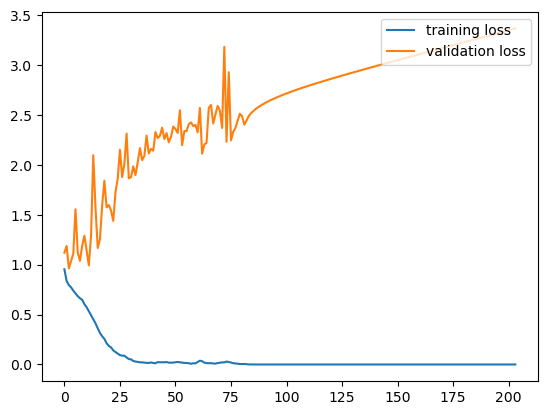

20
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554845/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554845/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0285 loss_val: 0.9672 time: 26.0454s
 Epoch: 0001 loss_train: 0.9093 loss_val: 1.0837 time: 26.0119s
 Epoch: 0002 loss_train: 0.8695 loss_val: 1.7176 time: 27.6101s
 Epoch: 0003 loss_train: 0.8342 loss_val: 1.0569 time: 28.4362s
 Epoch: 0004 loss_train: 0.8054 loss_val: 2.5833 time: 27.8499s
 Epoch: 0005 loss_train: 0.7813 loss_val: 2.7527 time: 27.2669s
 Epoch: 0006 loss_train: 0.7510 loss_val: 1.0191 time: 26.9275s
 Epoch: 0007 loss_train: 0.7255 loss_val: 1.5921 time: 30.4253s
 Epoch: 0008 loss_train: 0.6893 loss_val: 2.5543 time: 27.1976s
 Epoch: 0009 loss_train: 0.6554 loss_val: 3.4654 time: 28.2684s
 Epoch: 0010 loss_train: 0.6253 loss_val: 2.5797 time: 28.2639s
 Epoch: 0011 loss_train: 0.5871 loss_val: 2.3396 time: 27.0326s
 Epoch: 0012 loss_train: 0.5575 loss_val: 1.8355 time: 28.0170s
 Epoch: 0013 loss_train: 0.5271 loss_val: 1.6848 time: 26.9708s
 Epoch: 0014 loss_train: 0.4772 loss_val: 1.6466 time: 27.9390s
 Epoch: 0015 loss_train: 0.4264 loss_val

 Epoch: 0129 loss_train: 0.0050 loss_val: 3.0270 time: 28.0373s
 Epoch: 0130 loss_train: 0.0039 loss_val: 3.0920 time: 28.2757s
 Epoch: 0131 loss_train: 0.0043 loss_val: 3.0807 time: 28.6237s
 Epoch: 0132 loss_train: 0.0076 loss_val: 3.3101 time: 28.1534s
 Epoch: 0133 loss_train: 0.0674 loss_val: 3.1733 time: 27.7836s
 Epoch: 0134 loss_train: 0.0560 loss_val: 2.5196 time: 28.6770s
 Epoch: 0135 loss_train: 0.0214 loss_val: 3.0809 time: 25.5151s
 Epoch: 0136 loss_train: 0.0140 loss_val: 3.1755 time: 25.3843s
 Epoch: 0137 loss_train: 0.0098 loss_val: 3.0707 time: 25.8723s
 Epoch: 0138 loss_train: 0.0065 loss_val: 3.0742 time: 25.6065s
 Epoch: 0139 loss_train: 0.0038 loss_val: 3.1996 time: 26.3040s
 Epoch: 0140 loss_train: 0.0034 loss_val: 3.2983 time: 26.5247s
 Epoch: 0141 loss_train: 0.0034 loss_val: 3.3242 time: 29.2102s
 Epoch: 0142 loss_train: 0.0043 loss_val: 3.4022 time: 29.3533s
 Epoch: 0143 loss_train: 0.0038 loss_val: 3.4534 time: 27.7296s
 Epoch: 0144 loss_train: 0.0041 loss_val

 Epoch: 0262 loss_train: 0.0002 loss_val: 2.8064 time: 28.2481s
 Epoch: 0263 loss_train: 0.0003 loss_val: 2.8475 time: 28.6927s
 Epoch: 0264 loss_train: 0.0003 loss_val: 2.8494 time: 28.1166s
 Epoch: 0265 loss_train: 0.0008 loss_val: 2.8876 time: 29.0443s
 Epoch: 0266 loss_train: 0.0008 loss_val: 2.8518 time: 26.7135s
 Epoch: 0267 loss_train: 0.0022 loss_val: 2.8584 time: 29.9178s
 Epoch: 0268 loss_train: 0.0022 loss_val: 2.8428 time: 29.3365s
 Epoch: 0269 loss_train: 0.0020 loss_val: 2.9140 time: 28.8646s
 Epoch: 0270 loss_train: 0.0014 loss_val: 2.9687 time: 28.1890s
 Epoch: 0271 loss_train: 0.0018 loss_val: 3.0033 time: 28.0994s
 Epoch: 0272 loss_train: 0.0012 loss_val: 2.9440 time: 28.1849s
 Epoch: 0273 loss_train: 0.0016 loss_val: 3.0496 time: 29.6001s
 Epoch: 0274 loss_train: 0.0010 loss_val: 3.0477 time: 28.5555s
 Epoch: 0275 loss_train: 0.0018 loss_val: 3.0644 time: 27.1282s
 Epoch: 0276 loss_train: 0.0035 loss_val: 3.1321 time: 27.9036s
 Epoch: 0277 loss_train: 0.0501 loss_val

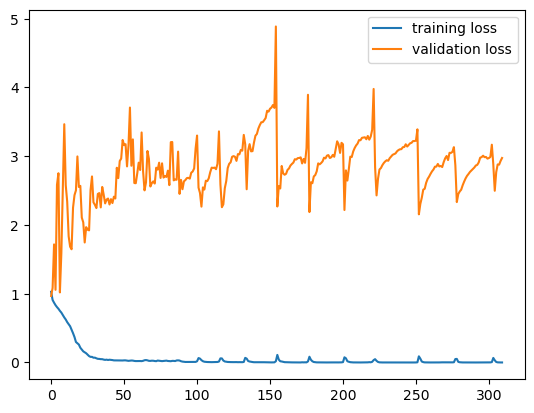

21
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
chromatin


/tmp/ipykernel_1554845/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554845/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0005 loss_val: 1.7332 time: 26.8700s
 Epoch: 0001 loss_train: 0.8690 loss_val: 1.2231 time: 29.7226s
 Epoch: 0002 loss_train: 0.8225 loss_val: 1.5639 time: 28.7624s
 Epoch: 0003 loss_train: 0.7844 loss_val: 1.2799 time: 28.1487s
 Epoch: 0004 loss_train: 0.7562 loss_val: 0.8528 time: 28.3615s
 Epoch: 0005 loss_train: 0.7292 loss_val: 1.5198 time: 28.0053s
 Epoch: 0006 loss_train: 0.7015 loss_val: 2.1998 time: 27.9563s
 Epoch: 0007 loss_train: 0.6705 loss_val: 1.7789 time: 28.8777s
 Epoch: 0008 loss_train: 0.6530 loss_val: 2.1279 time: 29.1128s
 Epoch: 0009 loss_train: 0.6145 loss_val: 1.2227 time: 29.3931s
 Epoch: 0010 loss_train: 0.5821 loss_val: 1.1632 time: 27.6771s
 Epoch: 0011 loss_train: 0.5400 loss_val: 1.0428 time: 27.6105s
 Epoch: 0012 loss_train: 0.5008 loss_val: 1.4235 time: 28.2363s
 Epoch: 0013 loss_train: 0.4531 loss_val: 0.9919 time: 29.3435s
 Epoch: 0014 loss_train: 0.4211 loss_val: 1.2883 time: 29.0661s
 Epoch: 0015 loss_train: 0.3914 loss_val

 Epoch: 0129 loss_train: 0.0060 loss_val: 2.4036 time: 27.0201s
 Epoch: 0130 loss_train: 0.0046 loss_val: 2.4479 time: 27.8420s
 Epoch: 0131 loss_train: 0.0047 loss_val: 2.4179 time: 29.0216s
 Epoch: 0132 loss_train: 0.0040 loss_val: 2.4264 time: 28.9310s
 Epoch: 0133 loss_train: 0.0049 loss_val: 2.3683 time: 27.9543s
 Epoch: 0134 loss_train: 0.0044 loss_val: 2.4931 time: 28.6236s
 Epoch: 0135 loss_train: 0.0053 loss_val: 2.4696 time: 29.6367s
 Epoch: 0136 loss_train: 0.0090 loss_val: 3.0754 time: 30.2844s
 Epoch: 0137 loss_train: 0.0765 loss_val: 3.5332 time: 27.9521s
 Epoch: 0138 loss_train: 0.0562 loss_val: 2.1319 time: 28.8070s
 Epoch: 0139 loss_train: 0.0239 loss_val: 2.9617 time: 28.9107s
 Epoch: 0140 loss_train: 0.0111 loss_val: 2.1873 time: 27.7064s
 Epoch: 0141 loss_train: 0.0073 loss_val: 2.2803 time: 27.9203s
 Epoch: 0142 loss_train: 0.0070 loss_val: 2.2959 time: 28.4232s
 Epoch: 0143 loss_train: 0.0061 loss_val: 2.3444 time: 26.5654s
 Epoch: 0144 loss_train: 0.0055 loss_val

 Epoch: 0258 loss_train: 0.0004 loss_val: 2.2735 time: 26.5908s
 Epoch: 0259 loss_train: 0.0002 loss_val: 2.3017 time: 28.9972s
 Epoch: 0260 loss_train: 0.0003 loss_val: 2.3165 time: 28.9688s
 Epoch: 0261 loss_train: 0.0002 loss_val: 2.3322 time: 28.3720s
 Epoch: 0262 loss_train: 0.0002 loss_val: 2.3484 time: 28.7304s
 Epoch: 0263 loss_train: 0.0002 loss_val: 2.3648 time: 26.9946s
 Epoch: 0264 loss_train: 0.0001 loss_val: 2.3803 time: 26.3024s
 Epoch: 0265 loss_train: 0.0001 loss_val: 2.3942 time: 26.3362s
 Epoch: 0266 loss_train: 0.0001 loss_val: 2.4076 time: 26.1361s
 Epoch: 0267 loss_train: 0.0001 loss_val: 2.4201 time: 26.3746s
 Epoch: 0268 loss_train: 0.0001 loss_val: 2.4324 time: 27.0872s
 Epoch: 0269 loss_train: 0.0001 loss_val: 2.4442 time: 26.7539s
 Epoch: 0270 loss_train: 0.0001 loss_val: 2.4544 time: 28.0046s
 Epoch: 0271 loss_train: 0.0001 loss_val: 2.4664 time: 28.7903s
 Epoch: 0272 loss_train: 0.0001 loss_val: 2.4772 time: 27.8178s
 Epoch: 0273 loss_train: 0.0001 loss_val

 Epoch: 0387 loss_train: 0.0001 loss_val: 2.4698 time: 28.0352s
 Epoch: 0388 loss_train: 0.0001 loss_val: 2.4796 time: 28.8852s
 Epoch: 0389 loss_train: 0.0001 loss_val: 2.4880 time: 29.0180s
 Epoch: 0390 loss_train: 0.0001 loss_val: 2.4993 time: 29.0848s
 Epoch: 0391 loss_train: 0.0001 loss_val: 2.5032 time: 28.0919s
 Epoch: 0392 loss_train: 0.0001 loss_val: 2.5201 time: 29.2144s
 Epoch: 0393 loss_train: 0.0001 loss_val: 2.5228 time: 29.0272s
 Epoch: 0394 loss_train: 0.0001 loss_val: 2.5392 time: 27.9101s
 Epoch: 0395 loss_train: 0.0011 loss_val: 2.5803 time: 29.3685s
 Epoch: 0396 loss_train: 0.0636 loss_val: 1.7878 time: 28.1152s
 Epoch: 0397 loss_train: 0.0689 loss_val: 1.6790 time: 28.9878s
 Epoch: 0398 loss_train: 0.0105 loss_val: 1.8833 time: 28.0165s
 Epoch: 0399 loss_train: 0.0026 loss_val: 1.9257 time: 29.0278s
 Epoch: 0400 loss_train: 0.0009 loss_val: 1.9807 time: 27.6131s
 Epoch: 0401 loss_train: 0.0005 loss_val: 2.0192 time: 29.0794s
 Epoch: 0402 loss_train: 0.0003 loss_val

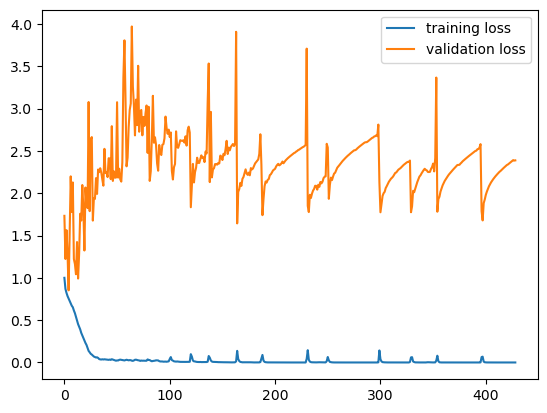

22
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554845/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554845/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0018 loss_val: 1.3418 time: 24.6450s
 Epoch: 0001 loss_train: 0.8676 loss_val: 1.2469 time: 25.8201s
 Epoch: 0002 loss_train: 0.8236 loss_val: 0.8890 time: 27.6274s
 Epoch: 0003 loss_train: 0.7898 loss_val: 1.3738 time: 28.4998s
 Epoch: 0004 loss_train: 0.7653 loss_val: 1.2666 time: 28.4208s
 Epoch: 0005 loss_train: 0.7425 loss_val: 1.1312 time: 26.2610s
 Epoch: 0006 loss_train: 0.7175 loss_val: 1.8631 time: 27.4940s
 Epoch: 0007 loss_train: 0.6929 loss_val: 1.4035 time: 26.7616s
 Epoch: 0008 loss_train: 0.6601 loss_val: 1.5161 time: 26.9591s
 Epoch: 0009 loss_train: 0.6234 loss_val: 1.6291 time: 27.2643s
 Epoch: 0010 loss_train: 0.5795 loss_val: 1.2996 time: 27.5051s
 Epoch: 0011 loss_train: 0.5469 loss_val: 1.5557 time: 28.2112s
 Epoch: 0012 loss_train: 0.5228 loss_val: 1.2513 time: 27.6853s
 Epoch: 0013 loss_train: 0.4710 loss_val: 1.2677 time: 27.6849s
 Epoch: 0014 loss_train: 0.4253 loss_val: 1.3251 time: 27.8412s
 Epoch: 0015 loss_train: 0.3887 loss_val

 Epoch: 0129 loss_train: 0.0070 loss_val: 2.8094 time: 26.4692s
 Epoch: 0130 loss_train: 0.0085 loss_val: 2.8366 time: 25.2991s
 Epoch: 0131 loss_train: 0.0814 loss_val: 2.0293 time: 27.5950s
 Epoch: 0132 loss_train: 0.0662 loss_val: 2.0143 time: 27.6801s
 Epoch: 0133 loss_train: 0.0228 loss_val: 2.0689 time: 28.9701s
 Epoch: 0134 loss_train: 0.0171 loss_val: 2.4552 time: 28.0892s
 Epoch: 0135 loss_train: 0.0101 loss_val: 2.4557 time: 27.9750s
 Epoch: 0136 loss_train: 0.0086 loss_val: 2.3688 time: 26.2902s
 Epoch: 0137 loss_train: 0.0098 loss_val: 2.4374 time: 28.2618s
 Epoch: 0138 loss_train: 0.0081 loss_val: 2.3026 time: 28.8646s
 Epoch: 0139 loss_train: 0.0076 loss_val: 2.3189 time: 29.1893s
 Epoch: 0140 loss_train: 0.0072 loss_val: 2.3786 time: 28.2733s
 Epoch: 0141 loss_train: 0.0070 loss_val: 2.4300 time: 28.0832s
 Epoch: 0142 loss_train: 0.0070 loss_val: 2.4726 time: 27.7822s
 Epoch: 0143 loss_train: 0.0070 loss_val: 2.4703 time: 27.1443s
 Epoch: 0144 loss_train: 0.0062 loss_val

 Epoch: 0258 loss_train: 0.0005 loss_val: 2.5686 time: 28.9633s
 Epoch: 0259 loss_train: 0.0008 loss_val: 2.5416 time: 28.4703s
 Epoch: 0260 loss_train: 0.0002 loss_val: 2.5530 time: 28.6506s
 Epoch: 0261 loss_train: 0.0001 loss_val: 2.5855 time: 28.9762s
 Epoch: 0262 loss_train: 0.0001 loss_val: 2.6007 time: 28.5883s
 Epoch: 0263 loss_train: 0.0001 loss_val: 2.6290 time: 26.8636s
 Epoch: 0264 loss_train: 0.0002 loss_val: 2.6329 time: 28.1989s
 Epoch: 0265 loss_train: 0.0004 loss_val: 2.6246 time: 26.5963s
 Epoch: 0266 loss_train: 0.0001 loss_val: 2.6491 time: 24.9141s
 Epoch: 0267 loss_train: 0.0001 loss_val: 2.6664 time: 28.0376s
 Epoch: 0268 loss_train: 0.0002 loss_val: 2.6837 time: 27.5254s
 Epoch: 0269 loss_train: 0.0002 loss_val: 2.7001 time: 28.2290s
 Epoch: 0270 loss_train: 0.0002 loss_val: 2.6971 time: 29.7627s
 Epoch: 0271 loss_train: 0.0002 loss_val: 2.7135 time: 27.8531s
 Epoch: 0272 loss_train: 0.0001 loss_val: 2.7226 time: 25.6709s
 Epoch: 0273 loss_train: 0.0001 loss_val

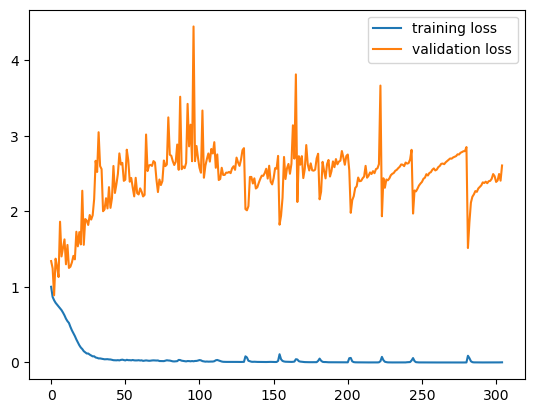

23
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554845/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554845/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0158 loss_val: 1.0689 time: 26.1080s
 Epoch: 0001 loss_train: 0.9012 loss_val: 1.0865 time: 25.6779s
 Epoch: 0002 loss_train: 0.8613 loss_val: 1.0362 time: 25.6301s
 Epoch: 0003 loss_train: 0.8283 loss_val: 2.0937 time: 22.5851s
 Epoch: 0004 loss_train: 0.7959 loss_val: 5.9657 time: 21.8589s
 Epoch: 0005 loss_train: 0.7699 loss_val: 2.6179 time: 25.1494s
 Epoch: 0006 loss_train: 0.7399 loss_val: 1.1844 time: 23.0726s
 Epoch: 0007 loss_train: 0.7157 loss_val: 1.2757 time: 26.1579s
 Epoch: 0008 loss_train: 0.6837 loss_val: 1.5703 time: 27.7451s
 Epoch: 0009 loss_train: 0.6718 loss_val: 1.1591 time: 28.6989s
 Epoch: 0010 loss_train: 0.6428 loss_val: 2.0861 time: 28.4721s
 Epoch: 0011 loss_train: 0.6426 loss_val: 2.7510 time: 28.5792s
 Epoch: 0012 loss_train: 0.5874 loss_val: 1.8322 time: 28.3681s
 Epoch: 0013 loss_train: 0.5332 loss_val: 1.7968 time: 28.1375s
 Epoch: 0014 loss_train: 0.4886 loss_val: 2.2952 time: 28.1659s
 Epoch: 0015 loss_train: 0.4522 loss_val

 Epoch: 0129 loss_train: 0.0079 loss_val: 2.7094 time: 29.2095s
 Epoch: 0130 loss_train: 0.0076 loss_val: 2.8776 time: 29.4655s
 Epoch: 0131 loss_train: 0.0076 loss_val: 2.7232 time: 28.1861s
 Epoch: 0132 loss_train: 0.0080 loss_val: 2.7651 time: 29.1211s
 Epoch: 0133 loss_train: 0.0087 loss_val: 2.7704 time: 27.7389s
 Epoch: 0134 loss_train: 0.0090 loss_val: 2.7577 time: 29.0365s
 Epoch: 0135 loss_train: 0.0553 loss_val: 3.1679 time: 29.8331s
 Epoch: 0136 loss_train: 0.0987 loss_val: 2.6085 time: 28.7778s
 Epoch: 0137 loss_train: 0.0293 loss_val: 2.0100 time: 28.7090s
 Epoch: 0138 loss_train: 0.0165 loss_val: 2.2887 time: 29.2781s
 Epoch: 0139 loss_train: 0.0107 loss_val: 2.3578 time: 27.9718s
 Epoch: 0140 loss_train: 0.0092 loss_val: 2.3303 time: 29.1825s
 Epoch: 0141 loss_train: 0.0084 loss_val: 2.2941 time: 28.1860s
 Epoch: 0142 loss_train: 0.0079 loss_val: 2.3101 time: 29.0392s
 Epoch: 0143 loss_train: 0.0083 loss_val: 2.3417 time: 27.0944s
 Epoch: 0144 loss_train: 0.0081 loss_val

 Epoch: 0258 loss_train: 0.0023 loss_val: 2.5046 time: 27.6026s
 Epoch: 0259 loss_train: 0.0016 loss_val: 2.5265 time: 28.8064s
 Epoch: 0260 loss_train: 0.0023 loss_val: 2.5459 time: 27.5026s
 Epoch: 0261 loss_train: 0.0031 loss_val: 2.5448 time: 29.8665s
 Epoch: 0262 loss_train: 0.0044 loss_val: 2.5585 time: 29.4291s
 Epoch: 0263 loss_train: 0.0042 loss_val: 2.5127 time: 27.8962s
 Epoch: 0264 loss_train: 0.0031 loss_val: 2.5700 time: 29.1236s
 Epoch: 0265 loss_train: 0.0026 loss_val: 2.5595 time: 27.5327s
 Epoch: 0266 loss_train: 0.0017 loss_val: 2.6037 time: 29.5066s
 Epoch: 0267 loss_train: 0.0021 loss_val: 2.6604 time: 28.3171s
 Epoch: 0268 loss_train: 0.0016 loss_val: 2.6774 time: 28.2314s
 Epoch: 0269 loss_train: 0.0014 loss_val: 2.6593 time: 29.1338s
 Epoch: 0270 loss_train: 0.0011 loss_val: 2.6973 time: 29.2738s
 Epoch: 0271 loss_train: 0.0011 loss_val: 2.7671 time: 28.6545s
 Epoch: 0272 loss_train: 0.0009 loss_val: 2.7579 time: 27.7429s
 Epoch: 0273 loss_train: 0.0010 loss_val

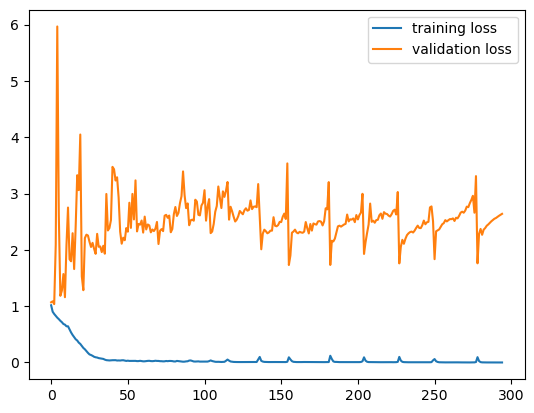

24
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554845/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554845/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9337 loss_val: 2.4494 time: 28.7130s
 Epoch: 0001 loss_train: 0.8046 loss_val: 1.4303 time: 29.8976s
 Epoch: 0002 loss_train: 0.7601 loss_val: 0.9483 time: 27.4551s
 Epoch: 0003 loss_train: 0.7302 loss_val: 1.0047 time: 28.3724s
 Epoch: 0004 loss_train: 0.7035 loss_val: 1.6754 time: 29.1179s
 Epoch: 0005 loss_train: 0.6763 loss_val: 0.8949 time: 28.2662s
 Epoch: 0006 loss_train: 0.6496 loss_val: 0.9262 time: 28.0987s
 Epoch: 0007 loss_train: 0.6206 loss_val: 1.3566 time: 30.0521s
 Epoch: 0008 loss_train: 0.5980 loss_val: 1.0193 time: 28.6132s
 Epoch: 0009 loss_train: 0.5838 loss_val: 1.0204 time: 29.0427s
 Epoch: 0010 loss_train: 0.5473 loss_val: 1.2019 time: 27.9171s
 Epoch: 0011 loss_train: 0.5071 loss_val: 1.2078 time: 27.8825s
 Epoch: 0012 loss_train: 0.4668 loss_val: 1.3287 time: 27.7876s
 Epoch: 0013 loss_train: 0.4308 loss_val: 1.5990 time: 28.0422s
 Epoch: 0014 loss_train: 0.3869 loss_val: 1.3626 time: 26.7595s
 Epoch: 0015 loss_train: 0.3520 loss_val

 Epoch: 0129 loss_train: 0.0053 loss_val: 2.4547 time: 28.1478s
 Epoch: 0130 loss_train: 0.0084 loss_val: 2.5897 time: 26.9771s
 Epoch: 0131 loss_train: 0.0813 loss_val: 1.5895 time: 28.1004s
 Epoch: 0132 loss_train: 0.0481 loss_val: 1.9603 time: 28.8445s
 Epoch: 0133 loss_train: 0.0214 loss_val: 1.9099 time: 28.5871s
 Epoch: 0134 loss_train: 0.0165 loss_val: 1.9636 time: 27.8560s
 Epoch: 0135 loss_train: 0.0109 loss_val: 2.1908 time: 28.3903s
 Epoch: 0136 loss_train: 0.0070 loss_val: 2.1842 time: 27.4234s
 Epoch: 0137 loss_train: 0.0072 loss_val: 3.3814 time: 28.7769s
 Epoch: 0138 loss_train: 0.0109 loss_val: 2.1315 time: 27.3332s
 Epoch: 0139 loss_train: 0.0109 loss_val: 2.5511 time: 29.7403s
 Epoch: 0140 loss_train: 0.0189 loss_val: 2.7476 time: 27.7453s
 Epoch: 0141 loss_train: 0.0356 loss_val: 1.9754 time: 29.0015s
 Epoch: 0142 loss_train: 0.0202 loss_val: 2.0951 time: 24.2322s
 Epoch: 0143 loss_train: 0.0126 loss_val: 2.9854 time: 22.5200s
 Epoch: 0144 loss_train: 0.0104 loss_val

 Epoch: 0258 loss_train: 0.0001 loss_val: 2.3042 time: 28.0342s
 Epoch: 0259 loss_train: 0.0001 loss_val: 2.3077 time: 27.4203s
 Epoch: 0260 loss_train: 0.0001 loss_val: 2.3241 time: 28.5111s
 Epoch: 0261 loss_train: 0.0002 loss_val: 2.3197 time: 27.6166s
 Epoch: 0262 loss_train: 0.0001 loss_val: 2.3398 time: 26.9261s
 Epoch: 0263 loss_train: 0.0001 loss_val: 2.3568 time: 25.5661s
 Epoch: 0264 loss_train: 0.0001 loss_val: 2.3585 time: 25.7024s
 Epoch: 0265 loss_train: 0.0001 loss_val: 2.3816 time: 26.0557s
 Epoch: 0266 loss_train: 0.0002 loss_val: 2.3640 time: 27.8673s
 Epoch: 0267 loss_train: 0.0002 loss_val: 2.3891 time: 28.8994s
 Epoch: 0268 loss_train: 0.0615 loss_val: 1.4127 time: 28.4042s
 Epoch: 0269 loss_train: 0.0798 loss_val: 1.6114 time: 28.2708s
 Epoch: 0270 loss_train: 0.0194 loss_val: 1.8724 time: 28.4724s
 Epoch: 0271 loss_train: 0.0097 loss_val: 2.2424 time: 28.5490s
 Epoch: 0272 loss_train: 0.0041 loss_val: 1.9866 time: 29.3761s
 Epoch: 0273 loss_train: 0.0025 loss_val

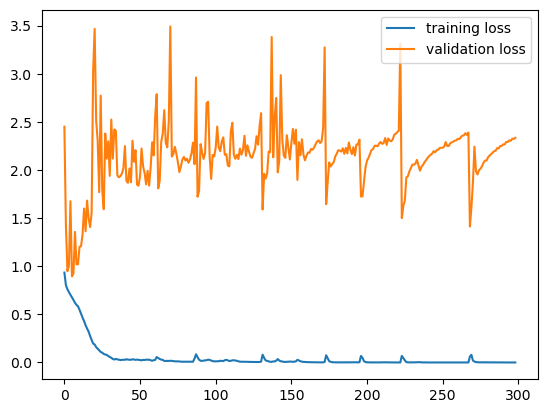

25
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554845/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554845/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9656 loss_val: 1.4354 time: 27.8993s
 Epoch: 0001 loss_train: 0.8512 loss_val: 0.9105 time: 28.3723s
 Epoch: 0002 loss_train: 0.8082 loss_val: 1.3695 time: 30.8195s
 Epoch: 0003 loss_train: 0.7784 loss_val: 1.0098 time: 28.7097s
 Epoch: 0004 loss_train: 0.7512 loss_val: 1.1306 time: 27.5681s
 Epoch: 0005 loss_train: 0.7205 loss_val: 1.3079 time: 28.3069s
 Epoch: 0006 loss_train: 0.6942 loss_val: 0.9753 time: 28.3497s
 Epoch: 0007 loss_train: 0.6679 loss_val: 1.1517 time: 27.4578s
 Epoch: 0008 loss_train: 0.6388 loss_val: 1.6498 time: 28.0170s
 Epoch: 0009 loss_train: 0.6110 loss_val: 1.1495 time: 28.4240s
 Epoch: 0010 loss_train: 0.5760 loss_val: 1.0933 time: 27.6997s
 Epoch: 0011 loss_train: 0.5423 loss_val: 1.1221 time: 28.8182s
 Epoch: 0012 loss_train: 0.4993 loss_val: 1.1736 time: 28.4203s
 Epoch: 0013 loss_train: 0.4652 loss_val: 1.6619 time: 29.0949s
 Epoch: 0014 loss_train: 0.4189 loss_val: 1.0943 time: 28.5904s
 Epoch: 0015 loss_train: 0.3748 loss_val

 Epoch: 0129 loss_train: 0.0000 loss_val: 2.7441 time: 27.3667s
 Epoch: 0130 loss_train: 0.0000 loss_val: 2.7499 time: 28.4392s
 Epoch: 0131 loss_train: 0.0000 loss_val: 2.7557 time: 28.3845s
 Epoch: 0132 loss_train: 0.0000 loss_val: 2.7616 time: 28.3172s
 Epoch: 0133 loss_train: 0.0000 loss_val: 2.7673 time: 29.1328s
 Epoch: 0134 loss_train: 0.0000 loss_val: 2.7731 time: 27.9486s
 Epoch: 0135 loss_train: 0.0000 loss_val: 2.7789 time: 28.5930s
 Epoch: 0136 loss_train: 0.0000 loss_val: 2.7847 time: 27.2619s
 Epoch: 0137 loss_train: 0.0000 loss_val: 2.7904 time: 28.5394s
 Epoch: 0138 loss_train: 0.0000 loss_val: 2.7963 time: 27.1754s
 Epoch: 0139 loss_train: 0.0000 loss_val: 2.8020 time: 27.2598s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.8078 time: 28.4529s
 Epoch: 0141 loss_train: 0.0000 loss_val: 2.8137 time: 28.3556s
 Epoch: 0142 loss_train: 0.0000 loss_val: 2.8194 time: 29.7771s
 Epoch: 0143 loss_train: 0.0000 loss_val: 2.8251 time: 28.7240s
 Epoch: 0144 loss_train: 0.0000 loss_val

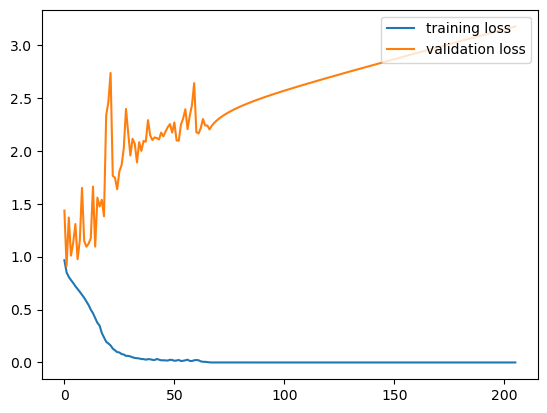

26
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554845/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554845/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0237 loss_val: 1.2749 time: 26.5929s
 Epoch: 0001 loss_train: 0.8997 loss_val: 3.1887 time: 21.3804s
 Epoch: 0002 loss_train: 0.8606 loss_val: 1.0396 time: 18.0932s
 Epoch: 0003 loss_train: 0.8339 loss_val: 1.4144 time: 21.0167s
 Epoch: 0004 loss_train: 0.8131 loss_val: 4.0610 time: 20.2328s
 Epoch: 0005 loss_train: 0.7891 loss_val: 2.6274 time: 21.0476s
 Epoch: 0006 loss_train: 0.7631 loss_val: 1.8249 time: 27.3687s
 Epoch: 0007 loss_train: 0.7263 loss_val: 0.9515 time: 28.8136s
 Epoch: 0008 loss_train: 0.7168 loss_val: 1.2018 time: 27.5030s
 Epoch: 0009 loss_train: 0.6986 loss_val: 1.1597 time: 28.4706s
 Epoch: 0010 loss_train: 0.6527 loss_val: 1.6318 time: 28.7528s
 Epoch: 0011 loss_train: 0.6158 loss_val: 1.2700 time: 28.4616s
 Epoch: 0012 loss_train: 0.5769 loss_val: 1.1136 time: 29.0626s
 Epoch: 0013 loss_train: 0.5236 loss_val: 1.2801 time: 27.4381s
 Epoch: 0014 loss_train: 0.4783 loss_val: 1.1152 time: 25.6257s
 Epoch: 0015 loss_train: 0.4343 loss_val

 Epoch: 0129 loss_train: 0.0264 loss_val: 4.1455 time: 27.8190s
 Epoch: 0130 loss_train: 0.1111 loss_val: 2.0880 time: 27.5968s
 Epoch: 0131 loss_train: 0.0518 loss_val: 2.1687 time: 28.3782s
 Epoch: 0132 loss_train: 0.0243 loss_val: 2.4327 time: 29.7259s
 Epoch: 0133 loss_train: 0.0110 loss_val: 2.6818 time: 28.3048s
 Epoch: 0134 loss_train: 0.0069 loss_val: 2.6447 time: 26.5007s
 Epoch: 0135 loss_train: 0.0049 loss_val: 2.6772 time: 28.3323s
 Epoch: 0136 loss_train: 0.0044 loss_val: 2.7825 time: 28.5368s
 Epoch: 0137 loss_train: 0.0038 loss_val: 2.7874 time: 29.6108s
 Epoch: 0138 loss_train: 0.0025 loss_val: 2.8025 time: 27.4037s
 Epoch: 0139 loss_train: 0.0024 loss_val: 2.8563 time: 28.5383s
 Epoch: 0140 loss_train: 0.0018 loss_val: 2.9320 time: 29.0247s
 Epoch: 0141 loss_train: 0.0018 loss_val: 2.9687 time: 26.8721s
 Epoch: 0142 loss_train: 0.0018 loss_val: 3.0638 time: 28.2602s
 Epoch: 0143 loss_train: 0.0020 loss_val: 2.9653 time: 28.3770s
 Epoch: 0144 loss_train: 0.0017 loss_val

 Epoch: 0258 loss_train: 0.0002 loss_val: 3.0308 time: 24.5224s
 Epoch: 0259 loss_train: 0.0001 loss_val: 3.0189 time: 25.2904s
 Epoch: 0260 loss_train: 0.0001 loss_val: 3.0532 time: 26.3411s
 Epoch: 0261 loss_train: 0.0001 loss_val: 3.0350 time: 23.8997s
 Epoch: 0262 loss_train: 0.0001 loss_val: 3.0798 time: 26.1720s
 Epoch: 0263 loss_train: 0.0001 loss_val: 3.0491 time: 29.0319s
 Epoch: 0264 loss_train: 0.0003 loss_val: 3.1260 time: 28.9557s
 Epoch: 0265 loss_train: 0.0006 loss_val: 2.9747 time: 28.9004s
 Epoch: 0266 loss_train: 0.0023 loss_val: 3.2391 time: 29.2807s
 Epoch: 0267 loss_train: 0.1126 loss_val: 1.6611 time: 27.4628s
 Epoch: 0268 loss_train: 0.0545 loss_val: 2.3301 time: 27.8144s
 Epoch: 0269 loss_train: 0.0158 loss_val: 2.4809 time: 29.3111s
 Epoch: 0270 loss_train: 0.0064 loss_val: 2.4942 time: 29.7482s
 Epoch: 0271 loss_train: 0.0015 loss_val: 2.6054 time: 27.1969s
 Epoch: 0272 loss_train: 0.0022 loss_val: 2.5975 time: 27.8301s
 Epoch: 0273 loss_train: 0.0010 loss_val

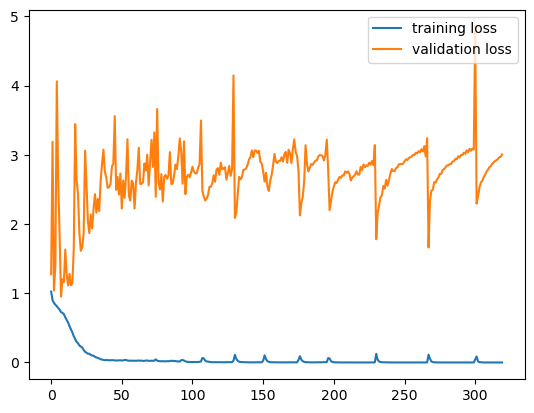

27
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
chromatin


/tmp/ipykernel_1554845/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554845/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9906 loss_val: 1.2288 time: 26.2351s
 Epoch: 0001 loss_train: 0.8577 loss_val: 1.0385 time: 27.5596s
 Epoch: 0002 loss_train: 0.8170 loss_val: 0.8688 time: 27.0896s
 Epoch: 0003 loss_train: 0.7909 loss_val: 1.0817 time: 25.2287s
 Epoch: 0004 loss_train: 0.7679 loss_val: 1.4371 time: 27.5605s
 Epoch: 0005 loss_train: 0.7366 loss_val: 1.2927 time: 28.1702s
 Epoch: 0006 loss_train: 0.7114 loss_val: 1.0428 time: 28.2381s
 Epoch: 0007 loss_train: 0.6881 loss_val: 1.0960 time: 28.5281s
 Epoch: 0008 loss_train: 0.6635 loss_val: 1.1072 time: 26.2266s
 Epoch: 0009 loss_train: 0.6327 loss_val: 1.1533 time: 27.7332s
 Epoch: 0010 loss_train: 0.5916 loss_val: 1.2187 time: 27.4805s
 Epoch: 0011 loss_train: 0.5536 loss_val: 1.4228 time: 28.0938s
 Epoch: 0012 loss_train: 0.5300 loss_val: 1.2339 time: 28.4989s
 Epoch: 0013 loss_train: 0.4926 loss_val: 1.0819 time: 27.8773s
 Epoch: 0014 loss_train: 0.4563 loss_val: 1.0824 time: 27.7593s
 Epoch: 0015 loss_train: 0.4237 loss_val

 Epoch: 0129 loss_train: 0.0038 loss_val: 2.5772 time: 28.4979s
 Epoch: 0130 loss_train: 0.0036 loss_val: 2.4737 time: 29.6617s
 Epoch: 0131 loss_train: 0.0040 loss_val: 2.4294 time: 28.8352s
 Epoch: 0132 loss_train: 0.0035 loss_val: 2.4534 time: 27.0917s
 Epoch: 0133 loss_train: 0.0037 loss_val: 2.4834 time: 27.4839s
 Epoch: 0134 loss_train: 0.0032 loss_val: 2.5247 time: 27.8512s
 Epoch: 0135 loss_train: 0.0031 loss_val: 2.5880 time: 28.2392s
 Epoch: 0136 loss_train: 0.0036 loss_val: 2.6660 time: 28.8694s
 Epoch: 0137 loss_train: 0.0074 loss_val: 3.2529 time: 29.3783s
 Epoch: 0138 loss_train: 0.1253 loss_val: 1.7267 time: 29.4101s
 Epoch: 0139 loss_train: 0.0459 loss_val: 1.8748 time: 26.8417s
 Epoch: 0140 loss_train: 0.0153 loss_val: 2.0568 time: 28.8059s
 Epoch: 0141 loss_train: 0.0068 loss_val: 2.3189 time: 28.3130s
 Epoch: 0142 loss_train: 0.0038 loss_val: 2.2670 time: 30.0904s
 Epoch: 0143 loss_train: 0.0035 loss_val: 2.2911 time: 28.4254s
 Epoch: 0144 loss_train: 0.0033 loss_val

 Epoch: 0258 loss_train: 0.0034 loss_val: 2.2871 time: 29.6516s
 Epoch: 0259 loss_train: 0.0019 loss_val: 2.3697 time: 29.8382s
 Epoch: 0260 loss_train: 0.0015 loss_val: 2.4149 time: 29.5505s
 Epoch: 0261 loss_train: 0.0003 loss_val: 2.4196 time: 30.0577s
 Epoch: 0262 loss_train: 0.0002 loss_val: 2.4475 time: 29.7541s
 Epoch: 0263 loss_train: 0.0001 loss_val: 2.4700 time: 26.6358s
 Epoch: 0264 loss_train: 0.0001 loss_val: 2.4921 time: 31.1419s
 Epoch: 0265 loss_train: 0.0001 loss_val: 2.5114 time: 30.5672s
 Epoch: 0266 loss_train: 0.0001 loss_val: 2.5312 time: 29.8783s
 Epoch: 0267 loss_train: 0.0001 loss_val: 2.5429 time: 29.5846s
 Epoch: 0268 loss_train: 0.0002 loss_val: 2.5320 time: 30.3278s
 Epoch: 0269 loss_train: 0.0001 loss_val: 2.5558 time: 27.2008s
 Epoch: 0270 loss_train: 0.0001 loss_val: 2.5580 time: 28.2772s
 Epoch: 0271 loss_train: 0.0002 loss_val: 2.5804 time: 27.7594s
 Epoch: 0272 loss_train: 0.0001 loss_val: 2.5783 time: 28.4746s
 Epoch: 0273 loss_train: 0.0001 loss_val

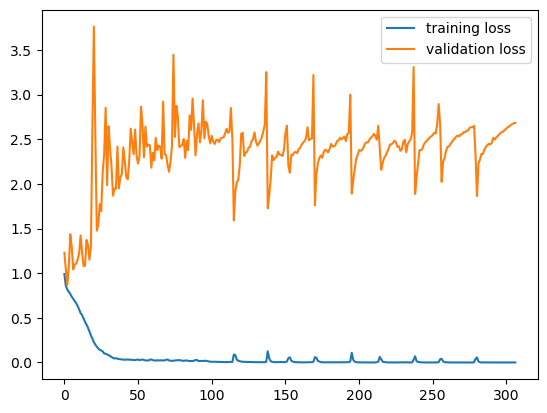

28
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554845/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554845/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0120 loss_val: 1.3941 time: 28.6714s
 Epoch: 0001 loss_train: 0.8827 loss_val: 1.3479 time: 28.7030s
 Epoch: 0002 loss_train: 0.8337 loss_val: 1.2954 time: 29.1006s
 Epoch: 0003 loss_train: 0.8040 loss_val: 1.0391 time: 28.8584s
 Epoch: 0004 loss_train: 0.7778 loss_val: 1.4717 time: 28.7586s
 Epoch: 0005 loss_train: 0.7504 loss_val: 1.5158 time: 28.6079s
 Epoch: 0006 loss_train: 0.7296 loss_val: 4.4770 time: 27.0122s
 Epoch: 0007 loss_train: 0.7057 loss_val: 1.2108 time: 28.6426s
 Epoch: 0008 loss_train: 0.6800 loss_val: 2.5762 time: 27.6332s
 Epoch: 0009 loss_train: 0.6393 loss_val: 1.1025 time: 27.3266s
 Epoch: 0010 loss_train: 0.6046 loss_val: 1.2124 time: 27.3809s
 Epoch: 0011 loss_train: 0.5566 loss_val: 1.5238 time: 23.7603s
 Epoch: 0012 loss_train: 0.5352 loss_val: 1.4916 time: 24.9497s
 Epoch: 0013 loss_train: 0.4818 loss_val: 2.1605 time: 24.3179s
 Epoch: 0014 loss_train: 0.4243 loss_val: 1.8319 time: 26.7166s
 Epoch: 0015 loss_train: 0.4024 loss_val

 Epoch: 0129 loss_train: 0.0334 loss_val: 2.3516 time: 28.9544s
 Epoch: 0130 loss_train: 0.0147 loss_val: 2.3056 time: 28.3287s
 Epoch: 0131 loss_train: 0.0080 loss_val: 2.4502 time: 29.3815s
 Epoch: 0132 loss_train: 0.0071 loss_val: 2.5278 time: 28.6476s
 Epoch: 0133 loss_train: 0.0060 loss_val: 2.4846 time: 27.9788s
 Epoch: 0134 loss_train: 0.0053 loss_val: 2.5305 time: 25.6676s
 Epoch: 0135 loss_train: 0.0046 loss_val: 2.6004 time: 26.7554s
 Epoch: 0136 loss_train: 0.0051 loss_val: 2.5643 time: 27.0810s
 Epoch: 0137 loss_train: 0.0042 loss_val: 2.5794 time: 28.2581s
 Epoch: 0138 loss_train: 0.0062 loss_val: 2.5258 time: 28.6335s
 Epoch: 0139 loss_train: 0.0046 loss_val: 2.5606 time: 30.0823s
 Epoch: 0140 loss_train: 0.0035 loss_val: 2.5602 time: 28.6783s
 Epoch: 0141 loss_train: 0.0039 loss_val: 2.6892 time: 29.9049s
 Epoch: 0142 loss_train: 0.0046 loss_val: 2.5969 time: 29.4048s
 Epoch: 0143 loss_train: 0.0035 loss_val: 2.6597 time: 29.0729s
 Epoch: 0144 loss_train: 0.0039 loss_val

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 Epoch: 0057 loss_train: 0.0303 loss_val: 2.0698 time: 30.4808s
 Epoch: 0058 loss_train: 0.0268 loss_val: 1.9904 time: 30.8299s
 Epoch: 0059 loss_train: 0.0213 loss_val: 2.4364 time: 29.3907s
 Epoch: 0060 loss_train: 0.0230 loss_val: 1.9986 time: 22.6307s
 Epoch: 0061 loss_train: 0.0268 loss_val: 2.6700 time: 23.6619s
 Epoch: 0062 loss_train: 0.0273 loss_val: 2.1096 time: 23.5803s
 Epoch: 0063 loss_train: 0.0308 loss_val: 2.2504 time: 23.0771s
 Epoch: 0064 loss_train: 0.0287 loss_val: 2.3656 time: 29.3180s
 Epoch: 0065 loss_train: 0.0227 loss_val: 3.5708 time: 30.6044s
 Epoch: 0066 loss_train: 0.0176 loss_val: 3.9320 time: 30.2991s
 Epoch: 0067 loss_train: 0.0157 loss_val: 2.7571 time: 30.4718s
 Epoch: 0068 loss_train: 0.0149 loss_val: 2.5059 time: 30.2041s
 Epoch: 0069 loss_train: 0.0191 loss_val: 2.3316 time: 29.4434s
 Epoch: 0070 loss_train: 0.0189 loss_val: 2.2967 time: 31.8058s
 Epoch: 0071 loss_train: 0.0289 loss_val: 2.4273 time: 29.2110s
 Epoch: 0072 loss_train: 0.0316 loss_val

 Epoch: 0186 loss_train: 0.0006 loss_val: 2.3043 time: 30.9529s
 Epoch: 0187 loss_train: 0.0005 loss_val: 2.3238 time: 30.1195s
 Epoch: 0188 loss_train: 0.0005 loss_val: 2.3410 time: 28.7699s
 Epoch: 0189 loss_train: 0.0005 loss_val: 2.3522 time: 29.7048s
 Epoch: 0190 loss_train: 0.0004 loss_val: 2.3705 time: 30.5618s
 Epoch: 0191 loss_train: 0.0004 loss_val: 2.3820 time: 29.6148s
 Epoch: 0192 loss_train: 0.0003 loss_val: 2.3982 time: 29.8791s
 Epoch: 0193 loss_train: 0.0004 loss_val: 2.4094 time: 29.6572s
 Epoch: 0194 loss_train: 0.0003 loss_val: 2.4309 time: 28.7765s
 Epoch: 0195 loss_train: 0.0004 loss_val: 2.4305 time: 30.2624s
 Epoch: 0196 loss_train: 0.0003 loss_val: 2.4445 time: 30.8089s
 Epoch: 0197 loss_train: 0.0003 loss_val: 2.4617 time: 29.9077s
 Epoch: 0198 loss_train: 0.0004 loss_val: 2.4615 time: 31.0340s
 Epoch: 0199 loss_train: 0.0005 loss_val: 2.5225 time: 30.5453s
 Epoch: 0200 loss_train: 0.0718 loss_val: 2.1242 time: 28.1204s
 Epoch: 0201 loss_train: 0.0791 loss_val

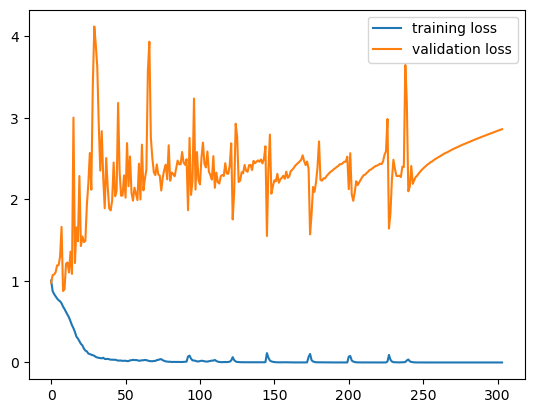

30
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554845/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554845/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9266 loss_val: 1.2851 time: 28.3576s
 Epoch: 0001 loss_train: 0.8075 loss_val: 1.2255 time: 28.3382s
 Epoch: 0002 loss_train: 0.7602 loss_val: 2.9322 time: 27.3198s
 Epoch: 0003 loss_train: 0.7298 loss_val: 1.1931 time: 27.3407s
 Epoch: 0004 loss_train: 0.7033 loss_val: 0.8544 time: 28.7162s
 Epoch: 0005 loss_train: 0.6776 loss_val: 0.8749 time: 27.3158s
 Epoch: 0006 loss_train: 0.6577 loss_val: 0.9772 time: 28.1708s
 Epoch: 0007 loss_train: 0.6265 loss_val: 1.1403 time: 28.6167s
 Epoch: 0008 loss_train: 0.5967 loss_val: 1.4612 time: 28.0314s
 Epoch: 0009 loss_train: 0.5715 loss_val: 2.1044 time: 28.7085s
 Epoch: 0010 loss_train: 0.5360 loss_val: 1.1005 time: 27.4235s
 Epoch: 0011 loss_train: 0.5270 loss_val: 1.8260 time: 27.1701s
 Epoch: 0012 loss_train: 0.4810 loss_val: 1.2496 time: 28.2827s
 Epoch: 0013 loss_train: 0.4433 loss_val: 2.2813 time: 27.3103s
 Epoch: 0014 loss_train: 0.4045 loss_val: 2.0616 time: 27.1838s
 Epoch: 0015 loss_train: 0.3689 loss_val

 Epoch: 0129 loss_train: 0.0054 loss_val: 2.3711 time: 31.1066s
 Epoch: 0133 loss_train: 0.0028 loss_val: 2.3679 time: 30.9569s
 Epoch: 0134 loss_train: 0.0028 loss_val: 2.3701 time: 31.1365s
 Epoch: 0135 loss_train: 0.0050 loss_val: 4.7482 time: 32.6785s
 Epoch: 0136 loss_train: 0.0445 loss_val: 2.5886 time: 30.7964s
 Epoch: 0137 loss_train: 0.0551 loss_val: 2.0790 time: 31.1051s
 Epoch: 0138 loss_train: 0.0207 loss_val: 2.1867 time: 31.5878s
 Epoch: 0139 loss_train: 0.0142 loss_val: 2.1886 time: 31.6126s
 Epoch: 0140 loss_train: 0.0116 loss_val: 2.5456 time: 30.2666s
 Epoch: 0141 loss_train: 0.0089 loss_val: 2.2244 time: 31.2133s
 Epoch: 0142 loss_train: 0.0061 loss_val: 2.4126 time: 30.4141s
 Epoch: 0143 loss_train: 0.0051 loss_val: 2.3382 time: 31.9498s
 Epoch: 0144 loss_train: 0.0045 loss_val: 2.4087 time: 31.7449s
 Epoch: 0145 loss_train: 0.0047 loss_val: 2.2932 time: 31.1792s
 Epoch: 0146 loss_train: 0.0042 loss_val: 2.3269 time: 31.1529s
 Epoch: 0147 loss_train: 0.0032 loss_val

 Epoch: 0261 loss_train: 0.0002 loss_val: 2.3405 time: 30.2342s
 Epoch: 0262 loss_train: 0.0002 loss_val: 2.3616 time: 30.6804s
 Epoch: 0263 loss_train: 0.0002 loss_val: 2.3896 time: 30.4897s
 Epoch: 0264 loss_train: 0.0002 loss_val: 2.4012 time: 29.9819s
 Epoch: 0265 loss_train: 0.0002 loss_val: 2.4224 time: 30.8256s
 Epoch: 0266 loss_train: 0.0002 loss_val: 2.4371 time: 30.4902s
 Epoch: 0267 loss_train: 0.0001 loss_val: 2.4534 time: 30.0231s
 Epoch: 0268 loss_train: 0.0001 loss_val: 2.4670 time: 29.9079s
 Epoch: 0269 loss_train: 0.0001 loss_val: 2.4960 time: 29.9721s
 Epoch: 0270 loss_train: 0.0002 loss_val: 2.4764 time: 31.1316s
 Epoch: 0271 loss_train: 0.0002 loss_val: 2.4870 time: 30.6292s
 Epoch: 0272 loss_train: 0.0001 loss_val: 2.5077 time: 30.8824s
 Epoch: 0273 loss_train: 0.0001 loss_val: 2.5178 time: 31.3402s
 Epoch: 0274 loss_train: 0.0001 loss_val: 2.5346 time: 31.5900s
 Epoch: 0275 loss_train: 0.0001 loss_val: 2.5404 time: 32.9208s
 Epoch: 0276 loss_train: 0.0001 loss_val

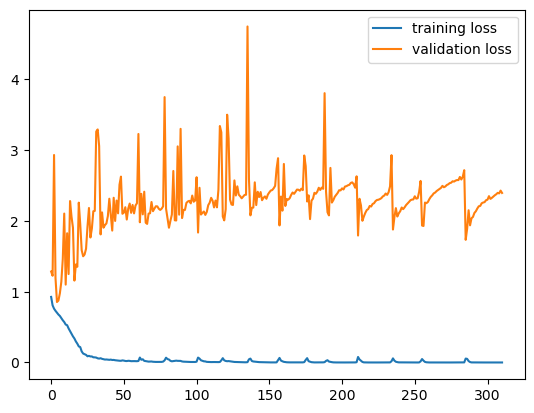

31
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554845/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554845/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 0.9598 loss_val: 0.9573 time: 33.1306s
 Epoch: 0001 loss_train: 0.8441 loss_val: 1.3250 time: 31.7352s
 Epoch: 0002 loss_train: 0.8048 loss_val: 1.1416 time: 30.6422s
 Epoch: 0003 loss_train: 0.7684 loss_val: 1.0823 time: 29.8145s
 Epoch: 0004 loss_train: 0.7404 loss_val: 0.9926 time: 30.3974s
 Epoch: 0005 loss_train: 0.7118 loss_val: 1.0240 time: 29.7258s
 Epoch: 0006 loss_train: 0.6839 loss_val: 1.1115 time: 31.4399s
 Epoch: 0007 loss_train: 0.6626 loss_val: 1.0854 time: 31.1178s
 Epoch: 0008 loss_train: 0.6429 loss_val: 1.2112 time: 31.0979s
 Epoch: 0009 loss_train: 0.6136 loss_val: 1.0978 time: 29.9734s
 Epoch: 0010 loss_train: 0.5707 loss_val: 1.8003 time: 29.4570s
 Epoch: 0011 loss_train: 0.5428 loss_val: 1.5261 time: 31.0751s
 Epoch: 0012 loss_train: 0.5250 loss_val: 1.5671 time: 29.1620s
 Epoch: 0013 loss_train: 0.4699 loss_val: 3.3803 time: 30.0931s
 Epoch: 0014 loss_train: 0.4343 loss_val: 2.1453 time: 30.7165s
 Epoch: 0015 loss_train: 0.3955 loss_val

 Epoch: 0129 loss_train: 0.0000 loss_val: 2.7333 time: 29.7538s
 Epoch: 0130 loss_train: 0.0000 loss_val: 2.7388 time: 28.7201s
 Epoch: 0131 loss_train: 0.0000 loss_val: 2.7443 time: 29.5359s
 Epoch: 0132 loss_train: 0.0000 loss_val: 2.7498 time: 30.3586s
 Epoch: 0133 loss_train: 0.0000 loss_val: 2.7553 time: 29.1506s
 Epoch: 0134 loss_train: 0.0000 loss_val: 2.7607 time: 28.6758s
 Epoch: 0135 loss_train: 0.0000 loss_val: 2.7662 time: 27.8222s
 Epoch: 0136 loss_train: 0.0000 loss_val: 2.7716 time: 27.1064s
 Epoch: 0137 loss_train: 0.0000 loss_val: 2.7771 time: 29.0867s
 Epoch: 0138 loss_train: 0.0000 loss_val: 2.7825 time: 29.6026s
 Epoch: 0139 loss_train: 0.0000 loss_val: 2.7879 time: 29.6577s
 Epoch: 0140 loss_train: 0.0000 loss_val: 2.7932 time: 30.4668s
 Epoch: 0141 loss_train: 0.0000 loss_val: 2.7986 time: 29.8793s
 Epoch: 0142 loss_train: 0.0000 loss_val: 2.8040 time: 29.4804s
 Epoch: 0143 loss_train: 0.0000 loss_val: 2.8093 time: 29.8473s
 Epoch: 0144 loss_train: 0.0000 loss_val

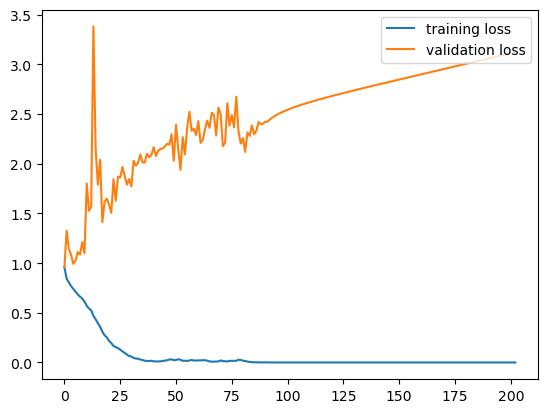

32
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554845/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554845/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0296 loss_val: 1.2300 time: 29.7639s
 Epoch: 0001 loss_train: 0.9055 loss_val: 1.4989 time: 30.8994s
 Epoch: 0002 loss_train: 0.8669 loss_val: 1.3870 time: 30.5620s
 Epoch: 0003 loss_train: 0.8379 loss_val: 1.0835 time: 30.2078s
 Epoch: 0004 loss_train: 0.8085 loss_val: 1.6528 time: 31.0902s
 Epoch: 0005 loss_train: 0.7854 loss_val: 1.0117 time: 30.5253s
 Epoch: 0006 loss_train: 0.7620 loss_val: 1.0500 time: 30.9013s
 Epoch: 0007 loss_train: 0.7385 loss_val: 1.3938 time: 29.2427s
 Epoch: 0008 loss_train: 0.7075 loss_val: 1.3296 time: 29.4692s
 Epoch: 0009 loss_train: 0.6810 loss_val: 0.9325 time: 30.3068s
 Epoch: 0010 loss_train: 0.6567 loss_val: 1.0484 time: 29.2184s
 Epoch: 0011 loss_train: 0.6126 loss_val: 4.2749 time: 29.7868s
 Epoch: 0012 loss_train: 0.5740 loss_val: 3.6631 time: 30.9823s
 Epoch: 0013 loss_train: 0.5245 loss_val: 2.4398 time: 30.2135s
 Epoch: 0014 loss_train: 0.4932 loss_val: 1.2395 time: 31.2591s
 Epoch: 0015 loss_train: 0.4710 loss_val

 Epoch: 0129 loss_train: 0.0061 loss_val: 2.7650 time: 30.9628s
 Epoch: 0130 loss_train: 0.0072 loss_val: 2.7561 time: 30.9942s
 Epoch: 0131 loss_train: 0.0270 loss_val: 3.0997 time: 29.9776s
 Epoch: 0132 loss_train: 0.0867 loss_val: 2.3321 time: 30.2267s
 Epoch: 0133 loss_train: 0.0345 loss_val: 2.3769 time: 31.4094s
 Epoch: 0134 loss_train: 0.0187 loss_val: 2.7228 time: 31.3438s
 Epoch: 0135 loss_train: 0.0149 loss_val: 2.6794 time: 29.8560s
 Epoch: 0136 loss_train: 0.0139 loss_val: 2.4910 time: 29.5982s
 Epoch: 0137 loss_train: 0.0112 loss_val: 2.5698 time: 30.1482s
 Epoch: 0138 loss_train: 0.0105 loss_val: 2.7088 time: 29.6566s
 Epoch: 0139 loss_train: 0.0111 loss_val: 2.9993 time: 30.9856s
 Epoch: 0140 loss_train: 0.0151 loss_val: 3.2264 time: 30.4231s
 Epoch: 0141 loss_train: 0.0194 loss_val: 2.8950 time: 30.3863s
 Epoch: 0142 loss_train: 0.0229 loss_val: 3.1731 time: 30.3356s
 Epoch: 0143 loss_train: 0.0218 loss_val: 2.8139 time: 30.3966s
 Epoch: 0144 loss_train: 0.0214 loss_val

 Epoch: 0258 loss_train: 0.0027 loss_val: 2.8156 time: 31.1863s
 Epoch: 0259 loss_train: 0.0013 loss_val: 2.8029 time: 29.5214s
 Epoch: 0260 loss_train: 0.0009 loss_val: 2.9243 time: 30.1531s
 Epoch: 0261 loss_train: 0.0019 loss_val: 3.0603 time: 29.6336s
 Epoch: 0262 loss_train: 0.0025 loss_val: 2.9149 time: 28.7841s
 Epoch: 0263 loss_train: 0.0126 loss_val: 3.2078 time: 29.2512s
 Epoch: 0264 loss_train: 0.0577 loss_val: 2.2569 time: 29.0010s
 Epoch: 0265 loss_train: 0.0243 loss_val: 2.4264 time: 29.7336s
 Epoch: 0266 loss_train: 0.0082 loss_val: 2.5882 time: 30.6143s
 Epoch: 0267 loss_train: 0.0022 loss_val: 2.5868 time: 29.2838s
 Epoch: 0268 loss_train: 0.0010 loss_val: 2.5959 time: 30.3842s
 Epoch: 0269 loss_train: 0.0004 loss_val: 2.6054 time: 29.7354s
 Epoch: 0270 loss_train: 0.0002 loss_val: 2.6319 time: 29.9555s
 Epoch: 0271 loss_train: 0.0002 loss_val: 2.6498 time: 30.9885s
 Epoch: 0272 loss_train: 0.0002 loss_val: 2.6851 time: 29.4113s
 Epoch: 0273 loss_train: 0.0001 loss_val

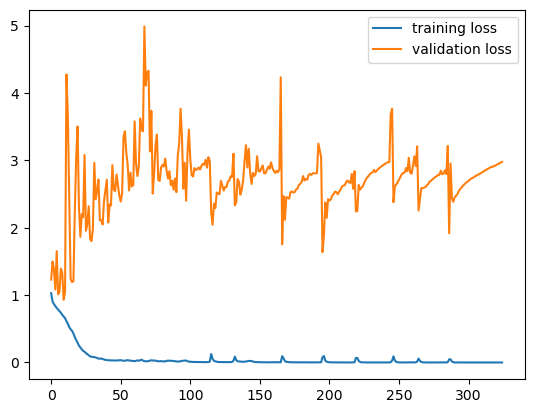

33
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
hold out: P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
P68
P16
P84
hold out: P15
chromatin


/tmp/ipykernel_1554845/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554845/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0061 loss_val: 1.0450 time: 29.8706s
 Epoch: 0001 loss_train: 0.8669 loss_val: 1.4725 time: 29.5728s
 Epoch: 0002 loss_train: 0.8217 loss_val: 1.0516 time: 30.8243s
 Epoch: 0003 loss_train: 0.7842 loss_val: 0.9634 time: 28.6734s
 Epoch: 0004 loss_train: 0.7536 loss_val: 0.8508 time: 30.0837s
 Epoch: 0005 loss_train: 0.7279 loss_val: 0.9003 time: 29.8409s
 Epoch: 0006 loss_train: 0.7071 loss_val: 1.1887 time: 31.1044s
 Epoch: 0007 loss_train: 0.6740 loss_val: 1.0058 time: 29.2005s
 Epoch: 0008 loss_train: 0.6435 loss_val: 1.5705 time: 29.1794s
 Epoch: 0009 loss_train: 0.6000 loss_val: 1.1801 time: 29.0514s
 Epoch: 0010 loss_train: 0.5772 loss_val: 1.0184 time: 28.9308s
 Epoch: 0011 loss_train: 0.5301 loss_val: 1.0273 time: 29.7661s
 Epoch: 0012 loss_train: 0.4867 loss_val: 1.0679 time: 29.2358s
 Epoch: 0013 loss_train: 0.4468 loss_val: 1.3436 time: 28.7524s
 Epoch: 0014 loss_train: 0.3896 loss_val: 1.1629 time: 27.8426s
 Epoch: 0015 loss_train: 0.3362 loss_val

 Epoch: 0129 loss_train: 0.0049 loss_val: 2.5541 time: 27.8285s
 Epoch: 0130 loss_train: 0.0094 loss_val: 3.5570 time: 28.1814s
 Epoch: 0131 loss_train: 0.0251 loss_val: 2.4423 time: 28.2424s
 Epoch: 0132 loss_train: 0.0436 loss_val: 2.0401 time: 29.4351s
 Epoch: 0133 loss_train: 0.0258 loss_val: 2.0075 time: 27.6980s
 Epoch: 0134 loss_train: 0.0136 loss_val: 2.2022 time: 28.3281s
 Epoch: 0135 loss_train: 0.0103 loss_val: 2.2481 time: 28.1352s
 Epoch: 0136 loss_train: 0.0100 loss_val: 2.2683 time: 29.6542s
 Epoch: 0137 loss_train: 0.0075 loss_val: 2.5814 time: 29.0192s
 Epoch: 0138 loss_train: 0.0071 loss_val: 2.3324 time: 29.6729s
 Epoch: 0139 loss_train: 0.0056 loss_val: 2.4024 time: 29.8802s
 Epoch: 0140 loss_train: 0.0050 loss_val: 2.3926 time: 28.9691s
 Epoch: 0141 loss_train: 0.0038 loss_val: 2.3969 time: 28.6942s
 Epoch: 0142 loss_train: 0.0035 loss_val: 2.3903 time: 27.5799s
 Epoch: 0143 loss_train: 0.0033 loss_val: 2.3638 time: 27.3348s
 Epoch: 0144 loss_train: 0.0030 loss_val

 Epoch: 0258 loss_train: 0.0005 loss_val: 2.1844 time: 28.3809s
 Epoch: 0259 loss_train: 0.0004 loss_val: 2.1919 time: 27.8279s
 Epoch: 0260 loss_train: 0.0004 loss_val: 2.2248 time: 28.6903s
 Epoch: 0261 loss_train: 0.0003 loss_val: 2.2310 time: 27.6082s
 Epoch: 0262 loss_train: 0.0002 loss_val: 2.2520 time: 27.1238s
 Epoch: 0263 loss_train: 0.0002 loss_val: 2.2547 time: 27.3947s
 Epoch: 0264 loss_train: 0.0002 loss_val: 2.2602 time: 28.3484s
 Epoch: 0265 loss_train: 0.0003 loss_val: 2.2818 time: 28.2986s
 Epoch: 0266 loss_train: 0.0002 loss_val: 2.2753 time: 28.1955s
 Epoch: 0267 loss_train: 0.0001 loss_val: 2.2880 time: 28.3468s
 Epoch: 0268 loss_train: 0.0001 loss_val: 2.3035 time: 28.1918s
 Epoch: 0269 loss_train: 0.0001 loss_val: 2.3200 time: 28.1899s
 Epoch: 0270 loss_train: 0.0002 loss_val: 2.3323 time: 28.9924s
 Epoch: 0271 loss_train: 0.0002 loss_val: 2.3536 time: 28.8281s
 Epoch: 0272 loss_train: 0.0002 loss_val: 2.3295 time: 28.9307s
 Epoch: 0273 loss_train: 0.0002 loss_val

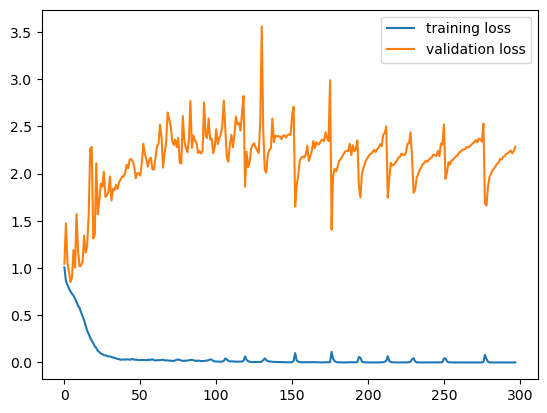

34
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
hold out: HV8
HV3
HV6
dapi_cd8_cd4
HV1
hold out: HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
hold out: P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
hold out: P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
hold out: P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
hold out: P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
hold out: P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
hold out: P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554845/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554845/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0047 loss_val: 0.9366 time: 28.6958s
 Epoch: 0001 loss_train: 0.8735 loss_val: 1.1702 time: 28.1854s
 Epoch: 0002 loss_train: 0.8352 loss_val: 0.9587 time: 28.9988s
 Epoch: 0003 loss_train: 0.8031 loss_val: 0.9173 time: 29.6141s
 Epoch: 0004 loss_train: 0.7761 loss_val: 1.1543 time: 29.8950s
 Epoch: 0005 loss_train: 0.7512 loss_val: 0.8913 time: 30.2507s
 Epoch: 0006 loss_train: 0.7232 loss_val: 1.0185 time: 28.6129s
 Epoch: 0007 loss_train: 0.7002 loss_val: 1.2910 time: 28.7102s
 Epoch: 0008 loss_train: 0.6739 loss_val: 1.1168 time: 28.6960s
 Epoch: 0009 loss_train: 0.6490 loss_val: 0.9738 time: 29.8908s
 Epoch: 0010 loss_train: 0.6207 loss_val: 1.2394 time: 28.7355s
 Epoch: 0011 loss_train: 0.5732 loss_val: 1.8350 time: 29.6312s
 Epoch: 0012 loss_train: 0.5405 loss_val: 1.5739 time: 29.3717s
 Epoch: 0013 loss_train: 0.5170 loss_val: 1.1417 time: 28.4713s
 Epoch: 0014 loss_train: 0.4817 loss_val: 1.2923 time: 29.5998s
 Epoch: 0015 loss_train: 0.4117 loss_val

 Epoch: 0129 loss_train: 0.0097 loss_val: 2.9285 time: 27.9342s
 Epoch: 0130 loss_train: 0.0074 loss_val: 3.2605 time: 27.8345s
 Epoch: 0131 loss_train: 0.0082 loss_val: 2.7226 time: 28.7426s
 Epoch: 0132 loss_train: 0.0149 loss_val: 2.9561 time: 28.3651s
 Epoch: 0133 loss_train: 0.0914 loss_val: 2.0759 time: 28.5846s
 Epoch: 0134 loss_train: 0.0333 loss_val: 2.0520 time: 29.4555s
 Epoch: 0135 loss_train: 0.0180 loss_val: 2.2724 time: 29.7298s
 Epoch: 0136 loss_train: 0.0195 loss_val: 2.3990 time: 28.8677s
 Epoch: 0137 loss_train: 0.0146 loss_val: 2.3098 time: 28.5340s
 Epoch: 0138 loss_train: 0.0081 loss_val: 2.5499 time: 27.9638s
 Epoch: 0139 loss_train: 0.0074 loss_val: 2.5415 time: 28.5473s
 Epoch: 0140 loss_train: 0.0071 loss_val: 2.4983 time: 28.8352s
 Epoch: 0141 loss_train: 0.0069 loss_val: 2.5127 time: 28.8579s
 Epoch: 0142 loss_train: 0.0064 loss_val: 2.6446 time: 28.9577s
 Epoch: 0143 loss_train: 0.0071 loss_val: 2.6204 time: 29.4370s
 Epoch: 0144 loss_train: 0.0064 loss_val

 Epoch: 0258 loss_train: 0.0006 loss_val: 2.5560 time: 28.5662s
 Epoch: 0259 loss_train: 0.0006 loss_val: 2.5792 time: 27.6358s
 Epoch: 0260 loss_train: 0.0006 loss_val: 2.5921 time: 28.4336s
 Epoch: 0261 loss_train: 0.0006 loss_val: 2.6038 time: 28.4992s
 Epoch: 0262 loss_train: 0.0008 loss_val: 2.6364 time: 28.1198s
 Epoch: 0263 loss_train: 0.0005 loss_val: 2.6122 time: 29.1218s
 Epoch: 0264 loss_train: 0.0006 loss_val: 2.6169 time: 29.0180s
 Epoch: 0265 loss_train: 0.0006 loss_val: 2.6418 time: 27.2868s
 Epoch: 0266 loss_train: 0.0018 loss_val: 2.7144 time: 26.1093s
 Epoch: 0267 loss_train: 0.0050 loss_val: 2.6473 time: 27.4286s
 Epoch: 0268 loss_train: 0.0096 loss_val: 2.8008 time: 29.1675s
 Epoch: 0269 loss_train: 0.0494 loss_val: 1.9380 time: 28.9091s
 Epoch: 0270 loss_train: 0.0331 loss_val: 2.0207 time: 28.4163s
 Epoch: 0271 loss_train: 0.0076 loss_val: 2.1928 time: 28.0449s
 Epoch: 0272 loss_train: 0.0026 loss_val: 2.2758 time: 28.0809s
 Epoch: 0273 loss_train: 0.0009 loss_val

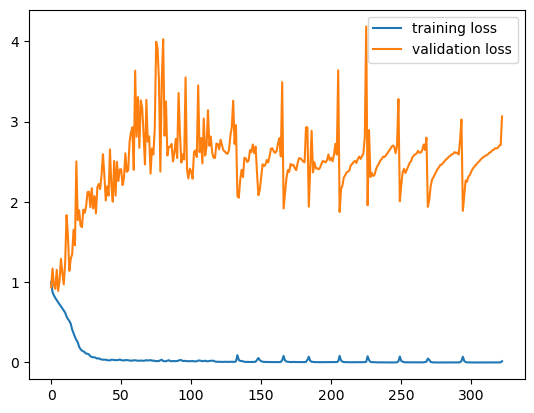

35
controls
dapi_gh2ax_lamin
HV5
HV4
hold out: HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
HV3
hold out: HV2
headneck
dapi_gh2ax_lamin_cd3
hold out: P72
P63
P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
hold out: P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
hold out: P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
hold out: P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
hold out: P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
hold out: P57
P22
P68
P16
P84
P15
chromatin


/tmp/ipykernel_1554845/580796571.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels=torch.tensor(labels_train[trainIdx]).cuda().long()
/tmp/ipykernel_1554845/580796571.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels=torch.tensor(labels_val[valIdx]).cuda().long()


 Epoch: 0000 loss_train: 1.0065 loss_val: 1.0735 time: 28.6201s
 Epoch: 0001 loss_train: 0.8767 loss_val: 0.9363 time: 29.3153s
 Epoch: 0002 loss_train: 0.8322 loss_val: 1.0253 time: 27.9644s
 Epoch: 0003 loss_train: 0.8038 loss_val: 0.9746 time: 28.7496s
 Epoch: 0004 loss_train: 0.7786 loss_val: 0.9412 time: 28.7921s
 Epoch: 0005 loss_train: 0.7560 loss_val: 0.9196 time: 28.1669s
 Epoch: 0006 loss_train: 0.7260 loss_val: 1.0600 time: 29.3456s
 Epoch: 0007 loss_train: 0.7041 loss_val: 1.1274 time: 29.8739s
 Epoch: 0008 loss_train: 0.6805 loss_val: 0.9869 time: 29.6935s
 Epoch: 0009 loss_train: 0.6460 loss_val: 1.8955 time: 29.7925s
 Epoch: 0010 loss_train: 0.6102 loss_val: 1.5462 time: 29.4238s
 Epoch: 0011 loss_train: 0.5752 loss_val: 1.3319 time: 29.1226s
 Epoch: 0012 loss_train: 0.5402 loss_val: 1.9609 time: 29.3935s
 Epoch: 0013 loss_train: 0.5079 loss_val: 1.6592 time: 30.3590s
 Epoch: 0014 loss_train: 0.4678 loss_val: 3.2068 time: 28.1200s
 Epoch: 0015 loss_train: 0.4197 loss_val

 Epoch: 0129 loss_train: 0.0026 loss_val: 2.5586 time: 28.6482s
 Epoch: 0130 loss_train: 0.0026 loss_val: 2.6275 time: 28.9025s
 Epoch: 0131 loss_train: 0.0025 loss_val: 2.7138 time: 29.1281s
 Epoch: 0132 loss_train: 0.0036 loss_val: 2.6070 time: 27.8752s
 Epoch: 0133 loss_train: 0.0021 loss_val: 2.6091 time: 29.0938s
 Epoch: 0134 loss_train: 0.0020 loss_val: 2.6498 time: 29.6353s
 Epoch: 0135 loss_train: 0.0030 loss_val: 2.5997 time: 28.7311s
 Epoch: 0136 loss_train: 0.0027 loss_val: 2.6397 time: 28.9670s
 Epoch: 0137 loss_train: 0.0018 loss_val: 2.6642 time: 28.9383s
 Epoch: 0138 loss_train: 0.0030 loss_val: 2.7241 time: 28.9240s
 Epoch: 0139 loss_train: 0.0063 loss_val: 3.3696 time: 29.2807s
 Epoch: 0140 loss_train: 0.0940 loss_val: 1.4735 time: 29.8535s
 Epoch: 0141 loss_train: 0.0552 loss_val: 2.3412 time: 29.7719s
 Epoch: 0142 loss_train: 0.0239 loss_val: 2.4191 time: 27.7320s
 Epoch: 0143 loss_train: 0.0114 loss_val: 2.4076 time: 28.9220s
 Epoch: 0144 loss_train: 0.0090 loss_val

 Epoch: 0258 loss_train: 0.0000 loss_val: 2.8818 time: 28.1420s
 Epoch: 0259 loss_train: 0.0000 loss_val: 2.8895 time: 29.6387s
 Epoch: 0260 loss_train: 0.0000 loss_val: 2.8971 time: 29.7935s
 Epoch: 0261 loss_train: 0.0000 loss_val: 2.9047 time: 30.0063s
 Epoch: 0262 loss_train: 0.0000 loss_val: 2.9123 time: 28.6445s
 Epoch: 0263 loss_train: 0.0000 loss_val: 2.9199 time: 28.9754s
 Epoch: 0264 loss_train: 0.0000 loss_val: 2.9272 time: 28.7845s
 Epoch: 0265 loss_train: 0.0000 loss_val: 2.9345 time: 28.7549s
 Epoch: 0266 loss_train: 0.0000 loss_val: 2.9420 time: 29.1367s
 Epoch: 0267 loss_train: 0.0000 loss_val: 2.9493 time: 27.9218s
 Epoch: 0268 loss_train: 0.0000 loss_val: 2.9565 time: 28.9054s
 Epoch: 0269 loss_train: 0.0000 loss_val: 2.9639 time: 29.2167s
 Epoch: 0270 loss_train: 0.0000 loss_val: 2.9712 time: 29.2050s
 Epoch: 0271 loss_train: 0.0000 loss_val: 2.9783 time: 28.4906s
 Epoch: 0272 loss_train: 0.0000 loss_val: 2.9856 time: 28.7972s
 Epoch: 0273 loss_train: 0.0000 loss_val

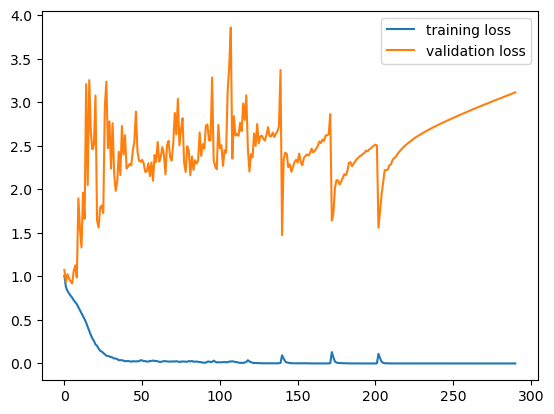

In [10]:
for sample_s in range(prevSampled,nSamples):
    print(sample_s)
    imgsC_all_samples_s=None
    imgsP_all_samples_s=None
    imgNames_all_samples_s=None
    proteinNames_samples_s=None
    pID_all_samples_s=None
    conditions_all_samples_s=None
    
    imgsC_all_val_samples_s={}
    imgsP_all_val_samples_s={}
    imgNames_all_val_samples_s={}
    proteinTrainInput_val_samples_s={}
    pID_all_val_samples_s={}
    conditions_all_val_samples_s={}
    for condition_i in conditions:
        print(condition_i)
        segDir_i=os.path.join(segDir,condition_i)
        imgDir_i=os.path.join(imgDir,condition_i)
        for stain in os.listdir(segDir_i):
            print(stain)
            segDir_i_stain=os.path.join(segDir_i,stain)
            imgDir_i_stain=os.path.join(imgDir_i,stain)

            segPID2name={}
            for pID_dir in os.listdir(segDir_i_stain):
                pID=pID_dir.split('_')
                segPID2name[pID[0]]=pID_dir
            imgPID2name={}
            for pID_dir in os.listdir(imgDir_i_stain):
                pID=pID_dir.split('_')
                imgPID2name[pID[0]]=pID_dir
            for pID in segPID2name.keys():
                if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                    continue
                if pID in holdOutSamples_samples[sample_s%6]:
                    print('hold out: '+pID)
                    continue
                print(pID)
                if pID not in imgPID2name:
                    print('img not found '+pID)
                    continue
                imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
                segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])

                with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                    imgNames=pickle.load(output)
                with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                    img=pickle.load(output)

                imgP=np.zeros((img.shape[0],1,img.shape[2],img.shape[3]))
                proteinNames_curr=np.array([])
                stain_list=stain.split('_')
                nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
                np.random.seed(sample_s+6)
                allIdx_all=np.arange(img.shape[0])
                np.random.shuffle(allIdx_all)
                for s in range(1,len(stain_list)):
                    s_start=(s-1)*nImgPerStain
                    if s==len(stain_list)-1:
                        s_end=img.shape[0]
                    else:
                        s_end=s*nImgPerStain
                    imgP[s_start:s_end]=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                    proteinNames_curr=np.concatenate((proteinNames_curr,np.repeat(stain_list[s],s_end-s_start)))

                    #store other channels for validation
                    for sother in range(1,len(stain_list)):
                        if sother==s:
                            continue
                        if stain_list[sother] not in imgsP_all_val_samples_s.keys():
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.repeat(stain_list[s],s_end-s_start)
                            pID_all_val_samples_s[stain_list[sother]]=np.repeat(pID,s_end-s_start)
                            imgsC_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            imgNames_all_val_samples_s[stain_list[sother]]=imgNames[allIdx_all[s_start:s_end]]
                            imgsP_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            conditions_all_val_samples_s[stain_list[sother]]=np.repeat(condition_i,s_end-s_start)
                        else:
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.concatenate((proteinTrainInput_val_samples_s[stain_list[sother]],np.repeat(stain_list[s],s_end-s_start)))
                            pID_all_val_samples_s[stain_list[sother]]=np.concatenate((pID_all_val_samples_s[stain_list[sother]],np.repeat(pID,s_end-s_start)))
                            imgsC_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsC_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            imgNames_all_val_samples_s[stain_list[sother]]=np.concatenate((imgNames_all_val_samples_s[stain_list[sother]],imgNames[allIdx_all[s_start:s_end]]))
                            imgsP_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsP_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            conditions_all_val_samples_s[stain_list[sother]]=np.concatenate((conditions_all_val_samples_s[stain_list[sother]],np.repeat(condition_i,s_end-s_start)))
                if pID_all_samples_s is None:
                    pID_all_samples_s=np.repeat(pID,img.shape[0])
                    imgsC_all_samples_s=img[allIdx_all,[0]]
                    imgNames_all_samples_s=imgNames[allIdx_all]
                    proteinNames_samples_s=proteinNames_curr
                    imgsP_all_samples_s=imgP
                    conditions_all_samples_s=np.repeat(condition_i,img.shape[0])
                else:
                    pID_all_samples_s=np.concatenate((pID_all_samples_s,np.repeat(pID,img.shape[0])))
                    imgsC_all_samples_s=np.concatenate((imgsC_all_samples_s,img[allIdx_all,[0]]),axis=0)
                    imgNames_all_samples_s=np.concatenate((imgNames_all_samples_s,imgNames[allIdx_all]))
                    proteinNames_samples_s=np.concatenate((proteinNames_samples_s,proteinNames_curr))
                    imgsP_all_samples_s=np.concatenate((imgsP_all_samples_s,imgP),axis=0)
                    conditions_all_samples_s=np.concatenate((conditions_all_samples_s,np.repeat(condition_i,img.shape[0])))
    imgsC_all_samples_s=imgsC_all_samples_s.reshape(imgsC_all_samples_s.shape[0],1,imgsC_all_samples_s.shape[1],imgsC_all_samples_s.shape[2])

    p_curr='chromatin'
    starget_index=0 #randomly selected protein ID for all chromatin images regardless of LO training ID

    print(p_curr)


    np.random.seed(sample_s+6)
    pctVal=0.1

    allIdx=np.arange(conditions_all_samples_s.size)
    np.random.shuffle(allIdx)
    valIdx=allIdx[:int(pctVal*allIdx.size)]
    trainIdx=allIdx[int(pctVal*allIdx.size):]

    logsavepath_train_curr=os.path.join(logsavepath_train,p_curr)
    modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr)
    plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr)
    if not os.path.exists(logsavepath_train_curr):
        os.mkdir(logsavepath_train_curr)
    if not os.path.exists(modelsavepath_train_curr):
        os.mkdir(modelsavepath_train_curr)
    if not os.path.exists(plotsavepath_train_curr):
        os.mkdir(plotsavepath_train_curr)
    logsavepath_train_curr=os.path.join(logsavepath_train,p_curr,str(sample_s+6))
    modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr,str(sample_s+6))
    plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr,str(sample_s+6))
    if not os.path.exists(logsavepath_train_curr):
        os.mkdir(logsavepath_train_curr)
    if not os.path.exists(modelsavepath_train_curr):
        os.mkdir(modelsavepath_train_curr)
    if not os.path.exists(plotsavepath_train_curr):
        os.mkdir(plotsavepath_train_curr)

    cnames,revIdx_c,cCounts=np.unique(conditions_all_samples_s[trainIdx],return_inverse=True,return_counts=True)
    clfWeight=1/cCounts
    clfWeight=clfWeight/np.sum(clfWeight)
    loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(clfWeight).cuda().float())
    cnames_val,revIdx_c_val,cCounts_val=np.unique(conditions_all_samples_s[valIdx],return_inverse=True,return_counts=True)

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True
    if modelname_train=='resnet18':
        model=torchvision.models.resnet18(num_classes=cnames.size)
        model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change to one input channel
    elif modelname_train=='alexnet':
        model=torchvision.models.alexnet(num_classes=cnames.size)
        model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    elif modelname_train=='cnn_base':
        model=model_clf.cnn_clf.CNN_VAE_clf(4, 2, 1, 1, 64,128,256,256,96, 96*4*4,64,cnames.size)
    model.cuda()
    optimizer_clf = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    #c2c - train samples
    plabels=torch.tensor(np.repeat(starget_index,trainIdx.size)).long()
    c2c_res_train=np.zeros_like(imgsC_all_samples_s[trainIdx])
    with torch.no_grad():
        nvalBatches=int(np.ceil(trainIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
            valtarget_dna=torch.tensor(imgsC_all_samples_s[valIdx_i]).cuda().float()
            valInput_ID=plabels[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])].cuda()
            valIdx_i=torch.tensor(valIdx_i)

            reconShared_dna_l,recon_dna_l= modelcnn_dna(valtarget_dna,valInput_ID)

            recon_dna=modelcnn_dnaShared_dec(reconShared_dna_l,pIDemb_dec(valInput_ID))
            c2c_res_train[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]=recon_dna.cpu().numpy()

    #c2c - validation samples
    plabels=torch.tensor(np.repeat(starget_index,valIdx.size)).long()
    c2c_res=np.zeros_like(imgsC_all_samples_s[valIdx])
    with torch.no_grad():
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            valtarget_dna=torch.tensor(imgsC_all_samples_s[valIdx_i]).cuda().float()
            valInput_ID=plabels[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])].cuda()
            valIdx_i=torch.tensor(valIdx_i)

            reconShared_dna_l,recon_dna_l= modelcnn_dna(valtarget_dna,valInput_ID)

            recon_dna=modelcnn_dnaShared_dec(reconShared_dna_l,pIDemb_dec(valInput_ID))
            c2c_res[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]=recon_dna.cpu().numpy()
    
    #train classifier
    train_loss=[np.inf]*epochs
    val_loss=[np.inf]*epochs

    t_ep=time.time()

    epCounts=0
    for ep in range(epochs):
        train_loss[ep],val_loss[ep]=train(ep,model,optimizer_clf,c2c_res_train,c2c_res,torch.tensor(revIdx_c),torch.tensor(revIdx_c_val))

        if ep>50 and val_loss[ep]>=val_loss[ep-50]:
            epCounts+=1

        if epCounts>150:
            break


        if ep%saveFreq == (saveFreq-1):
            torch.save(model.cpu().state_dict(), os.path.join(modelsavepath_train_curr,'ep'+str(ep)+'.pt'))


        model.cuda()
        torch.cuda.empty_cache()
    print(' total time: {:.4f}s'.format(time.time() - t_ep))


    with open(os.path.join(logsavepath_train_curr,'train_loss'), 'wb') as output:
        pickle.dump(train_loss, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath_train_curr,'val_loss'), 'wb') as output:
        pickle.dump(val_loss, output, pickle.HIGHEST_PROTOCOL)


    plt.plot(np.arange(epochs),train_loss)
    plt.plot(np.arange(epochs),val_loss)
    plt.legend(['training loss','validation loss'],loc='upper right')
    plt.savefig(os.path.join(plotsavepath_train_curr,'loss_seed3.jpg'))
    plt.show()



In [11]:
def plotCTcomp(labels,ctlist,savepath,savenamecluster,byCT,addname='',ctorder=None,vmin=None,vmax=None):
    if ctorder is None:
        ctorder=np.unique(ctlist)
    res=np.zeros((np.unique(labels).size,ctorder.size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=ctorder[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary',vmin=vmin,vmax=vmax)
    ax.set_yticks(np.arange(np.unique(labels).size))
    ax.set_yticklabels(np.unique(labels))
    ax.set_xticks(np.arange(ctorder.size))
    ax.set_xticklabels(ctorder)
    resplot=np.around(res,3)
    for i in range(resplot.shape[0]):
        for j in range(resplot.shape[1]):
            text = ax.text(j, i, resplot[i, j],
                           ha="center", va="center", color="r")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.colorbar(im)
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+addname+'.pdf'))
    plt.close()
    return res

In [12]:
p_curr='chromatin'
res_val=np.zeros((nSamples,cnames.size,cnames.size))
res_heldout=np.zeros((nSamples,cnames.size,cnames.size))
correctCount_val=[None]*nSamples
correctCount_heldout=[None]*nSamples

print(p_curr)

for sample_s in range(nSamples):
    imgsC_all_samples_s=None
    imgsP_all_samples_s=None
    imgNames_all_samples_s=None
    proteinNames_samples_s=None
    pID_all_samples_s=None
    conditions_all_samples_s=None
    
    imgsC_all_val_samples_s={}
    imgsP_all_val_samples_s={}
    imgNames_all_val_samples_s={}
    proteinTrainInput_val_samples_s={}
    pID_all_val_samples_s={}
    conditions_all_val_samples_s={}
    for condition_i in conditions:
        print(condition_i)
        segDir_i=os.path.join(segDir,condition_i)
        imgDir_i=os.path.join(imgDir,condition_i)
        for stain in os.listdir(segDir_i):
            print(stain)
            segDir_i_stain=os.path.join(segDir_i,stain)
            imgDir_i_stain=os.path.join(imgDir_i,stain)

            segPID2name={}
            for pID_dir in os.listdir(segDir_i_stain):
                pID=pID_dir.split('_')
                segPID2name[pID[0]]=pID_dir
            imgPID2name={}
            for pID_dir in os.listdir(imgDir_i_stain):
                pID=pID_dir.split('_')
                imgPID2name[pID[0]]=pID_dir
            for pID in segPID2name.keys():
                if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                    continue
                if pID in holdOutSamples_samples[sample_s%6]:
                    print('hold out: '+pID)
                    continue
                print(pID)
                if pID not in imgPID2name:
                    print('img not found '+pID)
                    continue
                imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
                segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])

                with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                    imgNames=pickle.load(output)
                with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                    img=pickle.load(output)

                imgP=np.zeros((img.shape[0],1,img.shape[2],img.shape[3]))
                proteinNames_curr=np.array([])
                stain_list=stain.split('_')
                nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
                np.random.seed(sample_s+6)
                allIdx_all=np.arange(img.shape[0])
                np.random.shuffle(allIdx_all)
                for s in range(1,len(stain_list)):
                    s_start=(s-1)*nImgPerStain
                    if s==len(stain_list)-1:
                        s_end=img.shape[0]
                    else:
                        s_end=s*nImgPerStain
                    imgP[s_start:s_end]=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                    proteinNames_curr=np.concatenate((proteinNames_curr,np.repeat(stain_list[s],s_end-s_start)))

                    #store other channels for validation
                    for sother in range(1,len(stain_list)):
                        if sother==s:
                            continue
                        if stain_list[sother] not in imgsP_all_val_samples_s.keys():
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.repeat(stain_list[s],s_end-s_start)
                            pID_all_val_samples_s[stain_list[sother]]=np.repeat(pID,s_end-s_start)
                            imgsC_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            imgNames_all_val_samples_s[stain_list[sother]]=imgNames[allIdx_all[s_start:s_end]]
                            imgsP_all_val_samples_s[stain_list[sother]]=img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                            conditions_all_val_samples_s[stain_list[sother]]=np.repeat(condition_i,s_end-s_start)
                        else:
                            proteinTrainInput_val_samples_s[stain_list[sother]]=np.concatenate((proteinTrainInput_val_samples_s[stain_list[sother]],np.repeat(stain_list[s],s_end-s_start)))
                            pID_all_val_samples_s[stain_list[sother]]=np.concatenate((pID_all_val_samples_s[stain_list[sother]],np.repeat(pID,s_end-s_start)))
                            imgsC_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsC_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],0].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            imgNames_all_val_samples_s[stain_list[sother]]=np.concatenate((imgNames_all_val_samples_s[stain_list[sother]],imgNames[allIdx_all[s_start:s_end]]))
                            imgsP_all_val_samples_s[stain_list[sother]]=np.concatenate((imgsP_all_val_samples_s[stain_list[sother]],img[allIdx_all[s_start:s_end],sother].reshape(s_end-s_start,1,img.shape[2],img.shape[3])),axis=0)
                            conditions_all_val_samples_s[stain_list[sother]]=np.concatenate((conditions_all_val_samples_s[stain_list[sother]],np.repeat(condition_i,s_end-s_start)))
                if pID_all_samples_s is None:
                    pID_all_samples_s=np.repeat(pID,img.shape[0])
                    imgsC_all_samples_s=img[allIdx_all,[0]]
                    imgNames_all_samples_s=imgNames[allIdx_all]
                    proteinNames_samples_s=proteinNames_curr
                    imgsP_all_samples_s=imgP
                    conditions_all_samples_s=np.repeat(condition_i,img.shape[0])
                else:
                    pID_all_samples_s=np.concatenate((pID_all_samples_s,np.repeat(pID,img.shape[0])))
                    imgsC_all_samples_s=np.concatenate((imgsC_all_samples_s,img[allIdx_all,[0]]),axis=0)
                    imgNames_all_samples_s=np.concatenate((imgNames_all_samples_s,imgNames[allIdx_all]))
                    proteinNames_samples_s=np.concatenate((proteinNames_samples_s,proteinNames_curr))
                    imgsP_all_samples_s=np.concatenate((imgsP_all_samples_s,imgP),axis=0)
                    conditions_all_samples_s=np.concatenate((conditions_all_samples_s,np.repeat(condition_i,img.shape[0])))
    imgsC_all_samples_s=imgsC_all_samples_s.reshape(imgsC_all_samples_s.shape[0],1,imgsC_all_samples_s.shape[1],imgsC_all_samples_s.shape[2])

    p_curr='chromatin'
    starget_index=0 #randomly selected protein ID for all chromatin images regardless of LO training ID

    print(p_curr)


    np.random.seed(sample_s+6)
    pctVal=0.1

    allIdx=np.arange(conditions_all_samples_s.size)
    np.random.shuffle(allIdx)
    valIdx=allIdx[:int(pctVal*allIdx.size)]
    trainIdx=allIdx[int(pctVal*allIdx.size):]

    plotsavepath_train_p=os.path.join(plotsavepath_train,p_curr)

    logsavepath_train_curr=os.path.join(logsavepath_train,p_curr,str(sample_s+6))
    modelsavepath_train_curr=os.path.join(modelsavepath_train,p_curr,str(sample_s+6))
    plotsavepath_train_curr=os.path.join(plotsavepath_train,p_curr,str(sample_s+6))

    cnames,revIdx_c,cCounts=np.unique(conditions_all_samples_s[trainIdx],return_inverse=True,return_counts=True)
    clfWeight=1/cCounts
    clfWeight=clfWeight/np.sum(clfWeight)
    loss_clf=torch.nn.CrossEntropyLoss(weight=torch.tensor(clfWeight).cuda().float())
    cnames_val,revIdx_c_val,cCounts_val=np.unique(conditions_all_samples_s[valIdx],return_inverse=True,return_counts=True)

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True
    if modelname_train=='resnet18':
        model=torchvision.models.resnet18(num_classes=cnames.size)
        model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change to one input channel
    elif modelname_train=='alexnet':
        model=torchvision.models.alexnet(num_classes=cnames.size)
        model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    elif modelname_train=='cnn_base':
        model=model_clf.cnn_clf.CNN_VAE_clf(4, 2, 1, 1, 64,128,256,256,96, 96*4*4,64,cnames.size)
    model.cuda()

    with open(os.path.join(logsavepath_train_curr,'val_loss'), 'rb') as output:
        val_loss=pickle.load(output)
    minlossepoch=np.argmin(val_loss)
    minlossepoch_saved=int(np.round(minlossepoch/saveFreq)*saveFreq)-1
    if minlossepoch_saved==-1:
        minlossepoch_saved=saveFreq-1
    if val_loss[minlossepoch_saved-saveFreq]<val_loss[minlossepoch_saved]:
        if val_loss[minlossepoch_saved+saveFreq]<val_loss[minlossepoch_saved-saveFreq]:
            minlossepoch_saved=minlossepoch_saved+saveFreq
        else:
            minlossepoch_saved=minlossepoch_saved-saveFreq
    if minlossepoch_saved==-1:
        minlossepoch_saved=saveFreq-1
    model.load_state_dict(torch.load(os.path.join(modelsavepath_train_curr,'ep'+str(minlossepoch_saved)+'.pt')))

    #c2c - validation samples
    plabels=torch.tensor(np.repeat(starget_index,valIdx.size)).long()
    c2c_res=np.zeros_like(imgsC_all_samples_s[valIdx])
    with torch.no_grad():
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            valtarget_dna=torch.tensor(imgsC_all_samples_s[valIdx_i]).cuda().float()
            valInput_ID=plabels[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])].cuda()
            valIdx_i=torch.tensor(valIdx_i)

            reconShared_dna_l,recon_dna_l= modelcnn_dna(valtarget_dna,valInput_ID)

            recon_dna=modelcnn_dnaShared_dec(reconShared_dna_l,pIDemb_dec(valInput_ID))
            c2c_res[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]=recon_dna.cpu().numpy()
    
    #validation samples
    with torch.no_grad():
        model.eval()
        loss_val_all=0
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        pred_curr=np.array([])
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            val_labels=torch.tensor(revIdx_c_val[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]).cuda().long()
            valInput=torch.tensor(c2c_res[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]).cuda().float()


            pred = model(valInput)

            loss=loss_clf(pred, val_labels)
            loss_val_all+=loss.item()
            pred_curr=np.concatenate((pred_curr,np.argmax(pred.detach().cpu().numpy(),axis=1)))

        loss_val_all=loss_val_all/nvalBatches

    print('loss_val: {:.4f}'.format(loss_val_all))
    correctCount=np.sum(pred_curr==revIdx_c_val)/pred_curr.size
    print('acc: {:.4f}'.format(correctCount))

    pred_curr=pred_curr.astype(int)
    res_val[sample_s]=plotCTcomp(cnames[revIdx_c_val],cnames[pred_curr],plotsavepath_train_curr,'confusion_val_moreSamples',False,addname='',ctorder=None,vmin=0,vmax=1)
    correctCount_val[sample_s]=correctCount
    with open(os.path.join(plotsavepath_train_curr,'pred_val_moreSamples'), 'wb') as output:
        pickle.dump(pred_curr, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(plotsavepath_train_curr,'true_val_moreSamples'), 'wb') as output:
        pickle.dump(revIdx_c_val, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(plotsavepath_train_curr,'true_cnames_moreSamples'), 'wb') as output:
        pickle.dump(cnames, output, pickle.HIGHEST_PROTOCOL)


    
    
with open(os.path.join(plotsavepath_train_p,'acc_val_moreSamples'), 'wb') as output:
    pickle.dump(correctCount_val, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(plotsavepath_train_p,'confusion_val_moreSamples'), 'wb') as output:
    pickle.dump(res_val, output, pickle.HIGHEST_PROTOCOL)




chromatin
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15
chromatin
loss_val: 2.0941
acc: 0.6795
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dap

HV2
HV10
HV1
HV7
HV9
HV8
hold out: HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
HV5
hold out: HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
P55
P50
hold out: P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
P44
P63
P50
hold out: P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
P59
P38
P48
hold out: P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
hold out: P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
hold out: P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
hold out: P46
P47
P29
P52
P57
P22
P68
P16
P84
P15
chromatin
loss_val: 2.4846
acc: 0.6898
controls
dapi_gh2ax_lamin
hold out: HV5
HV4
HV2
HV10
HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83

HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
HV7
HV4
hold out: HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
hold out: P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
P14
P18
P41
hold out: P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
hold out: P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
hold out: P42
P48
P62
P38
P83
P37
P33
P70
P59
P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
P22
P84
P47
P57
P15
P29
img not found P29
hold out: P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
P22
hold out: P68
P16
P84
P15
chromatin
loss_val: 2.7456
acc: 0.6309
controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
HV1
hold out: HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
HV1
HV8
HV6
hold out: HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
P14
P44
P41
P56
P18
hold out: P55
P50
P24
dapi_cd16_cd4_cd8
hold out: P55
P56
P72
P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
P27
P70
P83
P42
hold out: P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
hold out: P59
P2

In [13]:
print('avg val acc: {:.4f}'.format(np.mean(correctCount_val)))
# print('avg held out acc: {:.4f}\n'.format(np.mean(correctCount_heldout)))

avg val acc: 0.6494
